# Ingenieria inversa a Google maps by Eixos  
 
## Table of contents
1. [Introducción](#t1)
2. [Conversión del fichero KMZ a GeoJSON](#t2)
    * [Anotaciones](#st1)
3. [Fase de súperposisión de la Base de datos y los polígonos:](#t3)
    * [Delimitnado la ciudad de barcelona](#st2)
4. [Revisión y limpieza de dataframe de Retail](#t4)
    1. [Comprobación y eliminación de registros nulos](#st3)
    2. [Conversión de pd a gpd](#st4)
    3. [Agregacion de categorias comerciales](#st5)
5. [Revisión y limpieza de dataframe de Franquicias](#t5)
6. [Verificación de los polígonos](#t6)
    * [Visualización de los puntos](#st6)

7. [Submuestra para pruebas de ubicación](#t7)
8. [Pruebas de ubicación de los puntos dentro de los polígonos](#t8)
9. [Ubicación de los puntos dentro de los polígonos](#t9)
10. [Generación de hexagonos de la ciudad](#t10)
11. [Ubicación de los puntos dentro de los hexagonos](#t11)
12. [Comenzando a crear el dataset definitivo](#t12)
    2. [Matching de base de datos y grandes franquicias mediante una lista](#st7)
    3. [Matching de anterior dataset y coincidencias de polygonos de Areas De Interes](#st8)
    4. [Matching de anterior dataset y coincidencias en polygonos Hexagonales](#st9)
13. [Adicional: Uso de herramienta chromedriver para realizar webscraping](#t13)
    * [Ordenar por ratings](#st10)
14. [Analísis de locales comerciales por hexángonos](#t14)
15. [Análisis Cualitativo](#t15)
16. [Análisis Cuantitivativo](#t16)
17. [Xtra Ki](#t17)
18. [Pruebas](#t18)

In [1]:
import numpy as np
import pandas as pd

# Introducción  <a name="t1"></a>  
El primer paso para conseguir los poligonos de las areas de interes de la Ciudad de Barcelona se realiza usando Google Maps. Esta herramienta tiene la opcion de poder dibujar poligonos sobre sus mapas. Es muy facil de esta manera pues aqui mismo las zonas de interes (las de color amarillo beige) son visibles. El proceso es bastante sencillo, se selecciona un sector geografico, se define con un poligono y luego se agrega marcadores de posicion. 
### #DataScience #GIS #Python #Pandas #SpatialAnalysis

In [69]:
%%HTML
<style>.dataframe th,td:first-child{background: rgb(63,87,124);background: linear-gradient(180deg, rgba(63,87,124,1) 0%, rgba(101,124,161,1) 100%, rgba(0,212,255,1) 100%);;
padding: 10px;font-family: monospace;font-size: 110%;color: white;border:1px dashed white;text-align:left !important;
-moz-border-radius: 3x;-webkit-border-radius: 3px;}.dataframe thead{border:none; !important;}</style>

<img src="gm_aoi_0.png">

El resultado final lo podemos ver de la siguiente manera:

<img src="gm_aoi.png">

Aproximadamente se han podido dibujar alrededor de 90 areas de interes

Al tener listos los poligonos, el siguiente paso es exportar el resultado. Aqui la unica opción es exportarlo a un fichero con el formato KMZ.  
Este tipo de fichero tiene como peculiaridad  que esta comprimido para que pueda ser utilizado como un fichero KML.  
El siguiente Script se resume en convertir el fichero KMZ a un formato `geoJSON` para que sea mas homogeneo en términos de usabilidad y compatibilidad en el resto del proyecto. Aunque en el camino tambien se evaluará si es posible convertirlo de manera intermedia a un fichero `CSV`, podría ser mas facil convertirlo de este orígen a un fichero `geoJSON`.

# Conversión del fichero KMZ a GeoJSON  <a name="t2"></a>

In [1]:
import numpy as np
import pandas as pd

In [352]:
from zipfile import ZipFile

In [353]:
filename = 'aoi_BCN.kmz'

In [354]:
kmz = ZipFile(filename, 'r')
kml = kmz.open('doc.kml', 'r')

In [355]:
import xml.sax, xml.sax.handler
class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {}
        self.buffer = ""
        self.name_tag = ""
       
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = ""
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
           
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
           
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
       
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
       
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag           
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""

In [356]:
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

In [357]:
 def build_table(mapping):
    sep = ','
       
    output = 'Name' + sep + 'Coordinates\n'
    points = ''
    lines = ''
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates'] + sep
       
        if 'LookAt' in mapping[key]: #points
            points += key + sep + coord_str + "\n"
        elif 'LineString' in mapping[key]: #lines
            lines += key + sep + coord_str + "\n"
        else: #shapes
            shapes += key + sep + coord_str + "\n"
    output += points + lines + shapes
    return output

In [ ]:
outstr = build_table(handler.mapping)
out_filename = filename[:-3] + "csv" #output filename same as input plus .csv
f = open(out_filename, "w")
f.write(outstr)
f.close()
print(outstr)

In [ ]:
sep = ','
zinput = str("aoi_1,")
f = open("aoi_BCN.txt", 'r')
for linea in f.readlines():
    if linea[-1] == '\n':
        linea = linea.strip()
    if linea == sep:
        linea = linea[:-1]
    if linea == zinput:
        linea = linea.split()
        x = x.replace("[", "").replace("]", "")
    print(linea)
f.close()

In [ ]:
import sys

with open("aoi_BCN.txt") as infile:
    for line in infile:
        line = sys.stdout.write(line.strip().replace(',0','\n').replace('ao','\nao'))

In [ ]:
        lista_a = line.split(',')
        frecuencia = []
        for w in lista_a:
            frecuencia.append(lista_a.count(w))
        print(len(frecuencia))

In [457]:
f.close()

In [450]:
d.write("Name,lat,lon\n")
with open("aoi_BCN.txt", 'r') as file:
    for n in file:
        for line in file:
            if zinput in line:
                d.write(line)
                break

In [448]:
def salto(nums, elems = 3):
    final = ''
    steps = 0
    for num in nums:
        steps += 1
        final += '%s, ' % num
        if steps == elems:
            final += '\n'
            steps = 0
    return final

In [449]:
g = open("final.txt", 'w')
g.write("Name,Coordinates,0\n")
with open("aoi_BCN_d.txt", 'r') as file:
    for n in file:
        for line in file:
            x = line.split()
            gg= salto(x)
            g.write(str(gg))
            print(gg)
            break

In [423]:
temp = pd.read_csv('aoi_BCN.csv') 

In [424]:
temp

,Name,Coordinates,0
0,aoi_1,,NaN
1,2.1304911,41.3822118,0.0
2,2.1310061,41.3814712,0.0
3,2.1326798,41.3820186,0.0
4,2.1319931,41.38321,0.0
...,...,...,...
3398,2.0727213,41.3567775,0.0
3399,2.0724423,41.3569225,0.0
3400,2.0717986,41.3565842,0.0
3401,2.0705969,41.356552,0.0


Se desearia construir un Script capaz de poder parsear directamente el formato `KMZ` a un fichero `CSV` con las columnas: Poligono, Latitud y longitud. Sin embargo aun no se ha desarrollado y en su lugar para ahorrar un poco de tiempo en este proceso se ha utilizado excel para corregir el formato:

<img src="excel_MAL.png">
<img src="excel_BIE.png">

In [4]:
polys = pd.read_csv('aoi_BCN_CORR.csv')
polys.head()

,Name,lon,lat
0,aoi_1,2.130491,41.382212
1,aoi_1,2.131006,41.381471
2,aoi_1,2.132680,41.382019
3,aoi_1,2.131993,41.383210
4,aoi_1,2.132980,41.383854


In [47]:
len(polys['Name'].unique())

114

In [320]:
data_filter = polys[polys.Name.isin(['aoi_3'])]#, 'aoi_4']) ]
(data_filter)
#1 ->25
#2 ->29
#3 ->5

,Name,lon,lat
54,aoi_3,2.145919,41.393738
55,aoi_3,2.146134,41.393433
56,aoi_3,2.146692,41.393787
57,aoi_3,2.146498,41.394141
58,aoi_3,2.145919,41.393738


In [321]:
data_filter['cor'] = '('+data_filter['lon'].astype(str)+', '+data_filter['lat'].astype(str)+')'

C:\Users\alter\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [322]:
data_filter

,Name,lon,lat,cor
54,aoi_3,2.145919,41.393738,"(2.1459191000000004, 41.3937384)"
55,aoi_3,2.146134,41.393433,"(2.1461337000000005, 41.3934325)"
56,aoi_3,2.146692,41.393787,"(2.1466916, 41.3937867)"
57,aoi_3,2.146498,41.394141,"(2.1464985, 41.3941408)"
58,aoi_3,2.145919,41.393738,"(2.1459191000000004, 41.3937384)"


In [323]:
txy = data_filter['Name'].unique()

In [324]:
txy

array(['aoi_3'], dtype=object)

In [325]:
for elem in txy:
    n = 1
    if elem == ('aoi_'+str(3)):
        print("{}".format(data_filter['cor']))

54    (2.1459191000000004, 41.3937384)
55    (2.1461337000000005, 41.3934325)
56             (2.1466916, 41.3937867)
57             (2.1464985, 41.3941408)
58    (2.1459191000000004, 41.3937384)
Name: cor, dtype: object


In [173]:
dt_new = data_filter[['Name','cor']]
dt_new.reset_index(drop=True, inplace=True)
dt_new

,Name,cor
0,aoi_3,"(2.1459191000000004,41.3937384)"
1,aoi_3,"(2.1461337000000005,41.3934325)"
2,aoi_3,"(2.1466916,41.3937867)"
3,aoi_3,"(2.1464985,41.3941408)"
4,aoi_3,"(2.1459191000000004,41.3937384)"


In [107]:
coor['Name'] = data_filter['Name']
coor = '('+(data_filter['lon']).astype(str)+ ','+(data_filter['lat']).astype(str)+')'

In [146]:
dt_neww = data_filter[['lat','lon']]

In [175]:
dt_neww

,lat,lon
54,41.393738,2.145919
55,41.393433,2.146134
56,41.393787,2.146692
57,41.394141,2.146498
58,41.393738,2.145919


In [174]:
dt_neww.to_csv('dt_neww.csv', header=False, index=False)

In [ ]:
import csv, json
from geojson import Feature, FeatureCollection, Point

features = []
with open('CurrentObs.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for latitude, longitude, weather, temp in reader:
        latitude, longitude = map(float, (latitude, longitude))
        features.append(
            Feature(
                geometry = Point((longitude, latitude)),
                properties = {
                    'weather': weather,
                    'temp': temp
                }
            )
        )

collection = FeatureCollection(features)
with open("GeoObs.json", "w") as f:
    f.write('%s' % collection)

In [257]:
import csv, json
from geojson import MultiPolygon

MultiPolygon([
     ([(3.78, 9.28), (-130.91, 1.52), (35.12, 72.234), (3.78, 9.28)],),
     ([(23.18, -34.29), (-1.31, -4.61), (3.41, 77.91), (23.18, -34.29)],)
 ]) 

{"coordinates": [[[[3.78, 9.28], [-130.91, 1.52], [35.12, 72.234], [3.78, 9.28]]], [[[23.18, -34.29], [-1.31, -4.61], [3.41, 77.91], [23.18, -34.29]]]], "type": "MultiPolygon"}

In [258]:
import csv, json
from geojson import MultiPolygon

MultiPolygon([
    ([(41.3937384,2.1459191), (41.3934325,2.1461337), (41.3937867,2.1466916), (41.3941408,2.1464985), (41.3937384,2.1459191)],)
 ]) 

{"coordinates": [[[[41.393738, 2.145919], [41.393433, 2.146134], [41.393787, 2.146692], [41.394141, 2.146498], [41.393738, 2.145919]]]], "type": "MultiPolygon"}

In [ ]:
import csv, json
from geojson import MultiPolygon

features = []
with open('t_prueb.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='|')
    for cor in reader:

        features.append(
            MultiPolygon(
                geometry = MultiPolygon(cor)
            )
        )

collection = MultiPolygon(features)
with open("GeoObs.json", "w") as f:
    f.write('%s' % collection)

In [256]:
import csv
import json
from collections import OrderedDict

li = []
with open('t_prueb.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for cor in reader:
        d = OrderedDict()
        d['geometry'] = {
            'coordinates': [str(cor)],
            'type': 'MultiPolygon'
        }
        li.append(d)

d = OrderedDict()
d['features'] = li
with open('GeoObs.json', 'w') as f:
    f.write('%s' % d)

In [12]:
from geojson import MultiPolygon

## Anotaciones:  <a name="st1"></a>
Aunque el deseo de esta seccion es realizar un script capaz de generar un fichero en geojson por cuestion de tiempo se ha decidido usar otra herramienta como `QGIS` para ingresar el fichero `KMZ` y obtener el fichero `geoJSON`.  
Sin embargo la inquietud sigue presente, ¿por qué?:
 * Porque tener un script propio puede ser más especifico al momento de generar el fichero geoJson.
 * Porque teniendo un script propio, nos desmarcamos de usar un software externo.
 * Tambien agregar que dicho script estaria disponible para usarlo directamente, por ejemplo, en una aplicacion web o en una appliace de la empresa si así se deseará.
 * Por último, la razón más notable, es que agilizaría y reduciría el tiempo de traducir los polígonos obtenidos desde gmaps a un fichero maleable.  
 
Por lo tanto la inquietud aun esta ahí y seria interesante desarrollarla en un futuro.

---

# Fase de súperposisión de la Base de datos y los polígonos: <a name="t3"></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd

In [3]:
ret_ds = pd.read_csv('EIXOS - TFM La Salle - Barcelona.csv', usecols=['id', 'layer_id', 'layer_esp', 'title',
                                                                      'number', 'street', 'x', 'y', 'lon', 'lat']) 
frn_ds = pd.read_csv('eixos_cadenes_franquicies.csv')
df_cate = pd.read_csv('Eixos_categorias.csv')
print('retail shape', ret_ds.shape)
print('franquicies shape',frn_ds.shape)
print('categories shape',df_cate.shape)

retail shape (80362, 10)
franquicies shape (999, 2)
categories shape (149, 3)


Nuevas categorias
54: insdepo 
127: nauind

## Delimitando la ciudad de barcelona  <a name="st2"></a>

In [4]:
ret_ds = ret_ds.loc[ret_ds['lat'] > 41.33088]
ret_ds = ret_ds.loc[ret_ds['lat'] < 41.45682]

ret_ds = ret_ds.loc[ret_ds['lon'] < 2.26]
ret_ds = ret_ds.loc[ret_ds['lon'] > 2.07049]

# Revisión y limpieza de dataframe de Retail:  <a name="t4"></a>

## 1. Comprobación y eliminación de registros nulos:  <a name="st3"></a>

In [5]:
ret_ds.head()

,id,layer_id,layer_esp,title,number,street,x,y,lon,lat
0,83969,12,taller mecánico,Garces Taller,78,CL ROCAFORT,429313.0,4581410.0,2.153513,41.379259
1,86258,146,"productos eróticos, sex shops, condoneria",Ritsch,17,CL MUNTANER,430057.0,4581961.0,2.162346,41.384287
2,83964,40,bares de copas,Lunch & Catering Bar,72,CL ROCAFORT,429327.0,4581395.0,2.153682,41.379125
3,83970,8,tienda de ropa,Galaxia Complements Dona,80,CL ROCAFORT,429306.0,4581417.0,2.153428,41.379321
4,74866,40,bares de copas,Celler de l`Abi,220,GV CORTS CATALANES,428345.0,4580326.0,2.142066,41.369410


In [6]:
ret_ds.dtypes

id             int64
layer_id       int64
layer_esp     object
title         object
number        object
street        object
x            float64
y            float64
lon          float64
lat          float64
dtype: object

In [7]:
ret_ds.columns

Index(['id', 'layer_id', 'layer_esp', 'title', 'number', 'street', 'x', 'y',
       'lon', 'lat'],
      dtype='object')

In [8]:
col = ret_ds.columns.tolist()
for column in col:
  print("{}: {}".format(column, ret_ds[column].isnull().sum()))

id: 0
layer_id: 0
layer_esp: 0
title: 1
number: 88
street: 0
x: 0
y: 0
lon: 0
lat: 0


In [9]:
ret_ds.dropna(inplace=True)
ret_ds.shape

(80062, 10)

## 2. Conversión de pd a gpd:  <a name="st4"></a>

In [10]:
geometry = [Point(xy) for xy in zip (ret_ds['lon'], ret_ds['lat'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(ret_ds, crs=crs, geometry=geometry)

In [11]:
gdf.head()

,id,layer_id,layer_esp,title,number,street,x,y,lon,lat,geometry
0,83969,12,taller mecánico,Garces Taller,78,CL ROCAFORT,429313.0,4581410.0,2.153513,41.379259,POINT (2.15351 41.37926)
1,86258,146,"productos eróticos, sex shops, condoneria",Ritsch,17,CL MUNTANER,430057.0,4581961.0,2.162346,41.384287,POINT (2.16235 41.38429)
2,83964,40,bares de copas,Lunch & Catering Bar,72,CL ROCAFORT,429327.0,4581395.0,2.153682,41.379125,POINT (2.15368 41.37913)
3,83970,8,tienda de ropa,Galaxia Complements Dona,80,CL ROCAFORT,429306.0,4581417.0,2.153428,41.379321,POINT (2.15343 41.37932)
4,74866,40,bares de copas,Celler de l`Abi,220,GV CORTS CATALANES,428345.0,4580326.0,2.142066,41.369410,POINT (2.14207 41.36941)


## 3. Agregacion de categorias comerciales  <a name="st5"></a>

In [12]:
df_cate.head()

,ID SECTOR,CODIGO SUBSECTOR,CODIGO SECTOR
0,46,admi,other
1,543,air,other
2,38,apar,tran
3,106,ardep,pers
4,35,arranj,serv


In [13]:
len(df_cate['CODIGO SECTOR'].unique())

10

In [14]:
df_cate['ID_SUBSECTOR'] = df_cate['CODIGO SECTOR']

In [15]:
df_cate.head()

,ID SECTOR,CODIGO SUBSECTOR,CODIGO SECTOR,ID_SUBSECTOR
0,46,admi,other,other
1,543,air,other,other
2,38,apar,tran,tran
3,106,ardep,pers,pers
4,35,arranj,serv,serv


In [16]:
df_cate.ID_SUBSECTOR = df_cate.ID_SUBSECTOR.astype("category").cat.codes

In [17]:
df_cate.head()

,ID SECTOR,CODIGO SUBSECTOR,CODIGO SECTOR,ID_SUBSECTOR
0,46,admi,other,5
1,543,air,other,5
2,38,apar,tran,9
3,106,ardep,pers,6
4,35,arranj,serv,8


In [18]:
df_cate['ID_SUBSECTOR'].unique()

array([5, 9, 6, 8, 1, 7, 2, 3, 0, 4], dtype=int64)

In [19]:
df_cate['CODIGO SECTOR'].unique()

array(['other', 'tran', 'pers', 'serv', 'cult', 'quot', 'host', 'llar',
       'altr', 'localb'], dtype=object)

In [20]:
len(df_cate['ID_SUBSECTOR'].unique())

10

Cambiar nombres y posicion de columnas:  
cod_sub 	cod_sec 	cod_id     layer_id

In [21]:
col = df_cate.columns.tolist()
for column in col:
  print("{}: {}".format(column, df_cate[column].isnull().sum()))

ID SECTOR: 0
CODIGO SUBSECTOR: 0
CODIGO SECTOR: 0
ID_SUBSECTOR: 0


`id sector -> 147 (layer_id)
id subsector -> 10 (sub_id)`

In [22]:
df_cate.rename(columns={'ID SECTOR':'layer_id'}, inplace=True)

In [23]:
gdf.shape

(80062, 11)

In [24]:
gdf = pd.merge(gdf, df_cate, on = 'layer_id', how='outer')
gdf.rename(columns={'layer_id':'id_subsec','layer_esp':'sector','CODIGO SUBSECTOR':'cod_sub','CODIGO SECTOR':'cod_sec','ID_SUBSECTOR':'id_sec'}, inplace=True)
gdf.head()

,id,id_subsec,sector,title,number,street,x,y,lon,lat,geometry,cod_sub,cod_sec,id_sec
0,83969.0,12,taller mecánico,Garces Taller,78,CL ROCAFORT,429313.0,4581410.0,2.153513,41.379259,POINT (2.15351 41.37926),tall,tran,9
1,117499.0,12,taller mecánico,Anton Solé,10,PZ NAVAS,429739.0,4580810.0,2.158677,41.373892,POINT (2.15868 41.37389),tall,tran,9
2,117503.0,12,taller mecánico,Auto.Carburación,1,CL TEODOR BONAPLATA,429786.0,4580886.0,2.159230,41.374581,POINT (2.15923 41.37458),tall,tran,9
3,117511.0,12,taller mecánico,"M.F, Flomart",30,PS MONTJUIC,430800.0,4580634.0,2.171383,41.372399,POINT (2.17138 41.37240),tall,tran,9
4,117515.0,12,taller mecánico,F.Espunes,68,PS MONTJUIC,430491.0,4580569.0,2.167696,41.371787,POINT (2.16770 41.37179),tall,tran,9


In [25]:
gdf.shape

(80081, 14)

In [26]:
gdf.isnull().values.any()

True

In [27]:
gdf.isnull()

,id,id_subsec,sector,title,number,street,x,y,lon,lat,geometry,cod_sub,cod_sec,id_sec
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80076,True,False,True,True,True,True,True,True,True,True,True,False,False,False
80077,True,False,True,True,True,True,True,True,True,True,True,False,False,False
80078,True,False,True,True,True,True,True,True,True,True,True,False,False,False
80079,True,False,True,True,True,True,True,True,True,True,True,False,False,False


In [28]:
gdf.isnull().any()

id            True
id_subsec    False
sector        True
title         True
number        True
street        True
x             True
y             True
lon           True
lat           True
geometry      True
cod_sub      False
cod_sec      False
id_sec       False
dtype: bool

In [29]:
gdf.isnull().sum()

id           19
id_subsec     0
sector       19
title        19
number       19
street       19
x            19
y            19
lon          19
lat          19
geometry     19
cod_sub       0
cod_sec       0
id_sec        0
dtype: int64

In [30]:
gdf.id.isnull().sum().sum()

19

In [31]:
nan_rows = gdf[gdf.id.isnull()]

In [32]:
len(nan_rows)

19

In [33]:
#nan_rows.head() #doesn´t work and I dont know why

In [34]:
gdf.columns[gdf.isnull().any()]

Index(['id', 'sector', 'title', 'number', 'street', 'x', 'y', 'lon', 'lat',
       'geometry'],
      dtype='object')

In [35]:
nan_rows['id_subsec'].unique()

array([543, 122,   1, 142, 138,  94, 130, 129, 154, 530, 544, 545, 546,
       547, 548, 549, 550, 552, 141], dtype=int64)

In [36]:
len(nan_rows['id_subsec'].unique())

19

In [37]:
gdf.shape

(80081, 14)

In [38]:
cols = gdf.columns.tolist()
cols

['id',
 'id_subsec',
 'sector',
 'title',
 'number',
 'street',
 'x',
 'y',
 'lon',
 'lat',
 'geometry',
 'cod_sub',
 'cod_sec',
 'id_sec']

In [39]:
cols = ['id',
'title',
'number',
'street',
'id_sec',
'id_subsec',
'cod_sec',
'cod_sub',
'sector',
'x',
'y',
'lon',
'lat',
'geometry']

In [40]:
gdf = gdf[cols]

In [41]:
gdf.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry
0,83969.0,Garces Taller,78,CL ROCAFORT,9,12,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.15351 41.37926)
1,117499.0,Anton Solé,10,PZ NAVAS,9,12,tran,tall,taller mecánico,429739.0,4580810.0,2.158677,41.373892,POINT (2.15868 41.37389)
2,117503.0,Auto.Carburación,1,CL TEODOR BONAPLATA,9,12,tran,tall,taller mecánico,429786.0,4580886.0,2.159230,41.374581,POINT (2.15923 41.37458)
3,117511.0,"M.F, Flomart",30,PS MONTJUIC,9,12,tran,tall,taller mecánico,430800.0,4580634.0,2.171383,41.372399,POINT (2.17138 41.37240)
4,117515.0,F.Espunes,68,PS MONTJUIC,9,12,tran,tall,taller mecánico,430491.0,4580569.0,2.167696,41.371787,POINT (2.16770 41.37179)


In [42]:
gdf.shape

(80081, 14)

In [43]:
gdf.drop(gdf[gdf.title.isnull()].index, inplace = True)
gdf.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry
0,83969.0,Garces Taller,78,CL ROCAFORT,9,12,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.15351 41.37926)
1,117499.0,Anton Solé,10,PZ NAVAS,9,12,tran,tall,taller mecánico,429739.0,4580810.0,2.158677,41.373892,POINT (2.15868 41.37389)
2,117503.0,Auto.Carburación,1,CL TEODOR BONAPLATA,9,12,tran,tall,taller mecánico,429786.0,4580886.0,2.159230,41.374581,POINT (2.15923 41.37458)
3,117511.0,"M.F, Flomart",30,PS MONTJUIC,9,12,tran,tall,taller mecánico,430800.0,4580634.0,2.171383,41.372399,POINT (2.17138 41.37240)
4,117515.0,F.Espunes,68,PS MONTJUIC,9,12,tran,tall,taller mecánico,430491.0,4580569.0,2.167696,41.371787,POINT (2.16770 41.37179)


In [44]:
gdf.shape

(80062, 14)

In [45]:
gdf.to_csv('ret_ds_CLEAN.csv', index=False)

# Revisión y limpieza de dataframe de Franquicias:  <a name="t5"></a>

In [276]:
frn_ds.head()

,CADENA,VALUE
0,Accezorize,1.0
1,Adidas,1.0
2,Adolfo Dominguez,1.0
3,Agua Viva,1.0
4,Ale -Hop,1.0


In [277]:
frn_ds['VALUE'].unique()

array([ 1., nan])

In [278]:
frn_ds.tail()

,CADENA,VALUE
994,NaN,NaN
995,NaN,NaN
996,NaN,NaN
997,NaN,NaN
998,NaN,NaN


In [279]:
frn_ds.shape

(999, 2)

In [280]:
frn_ds['VALUE'].unique()

array([ 1., nan])

In [281]:
frn_ds.dropna(inplace=True)

In [282]:
frn_ds.shape

(304, 2)

In [283]:
frn_ds.to_csv('frn_ds_CLEAN.csv', index=False)

# Verificación de los polígonos:  <a name="t6"></a>

In [46]:
import geopandas
import geoplot

In [47]:
map_data = gpd.read_file('aoi_BCN.geojson')
map_data.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry
0,aoi_1,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.13049 41.38221 0.00000, 2.13101 ..."
1,aoi_2,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14463 41.39321 0.00000, 2.14495 ..."
2,aoi_3,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14592 41.39374 0.00000, 2.14613 ..."
3,aoi_4,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14860 41.39433 0.00000, 2.14884 ..."
4,aoi_5,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14845 41.39443 0.00000, 2.14873 ..."


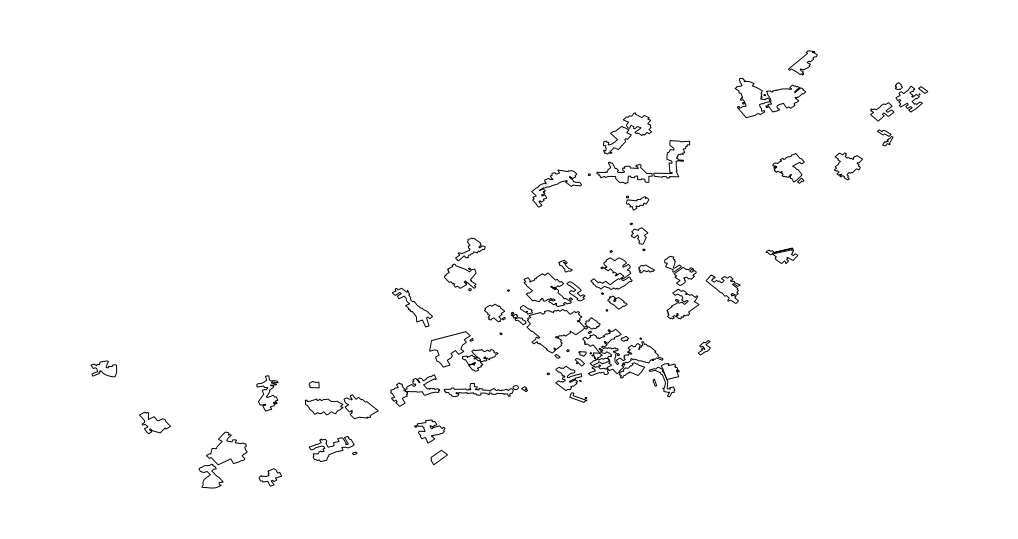

In [481]:
geoplot.polyplot(map_data, figsize=(18, 10))

## Visualización de los puntos:  <a name="st6"></a>
De ahora en adelante es importante conocer la localizacion en latitud y longitud de la ciudad que se esta analizando, en este caso las coordenadas pertenecen a la ciudad de Barcelona:  
```
Latitud..........Longitud
41.3887901........2.1589899
```

In [137]:
import geopandas as gpd
from shapely.geometry import Polygon

En el siguiente mapa podemos observar todas las ubicaciones de los centros comerciales y los polígonos superpuestos pero aun sin clasificar los que están dentro de los que estan afuera de los polígonos.

In [ ]:
import folium

m = folium.Map([41.3887901,2.1589899], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(map_data).add_to(m)
folium.LatLngPopup().add_to(m)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=2,
                        weight=1).add_to(m)
ret_ds.apply(plotDot, axis = 1)
m

<img src="ret_df.png">

# Submuestra para pruebas de ubicación <a name="t7"></a>

Para tal prueba se ha recurrido a buscar dos puntos en el mapa para delimitar dos esquinas de un virtual "cuadro" en donde se enmarcarían las ubicaciones en latitud y longitud de los locales comerciales situados dentro del cuadro.  
* Punto superior:  *41.39002, 2.12699*  
* Punto inferior: *41.37982, 2.14535*  

Polígonos involucrados dentro del recuadro:
   * aoi_ 1 -> 0. 
   * aoi_45 -> 44. 
   * aoi_46 -> 45. 
   * aoi_43 -> 42. 
   * aoi_9 -> 8.  

Array que contenga dichos polígonos:  
   * `vpol = [0, 42, 44, 45]` 

Una breve anotacíon interesante es que se deben desestimar los polígonos que aunque esten dentro del recuadro, no tengan algún local comercial dentro de sí, pues si se encuentra un polígono vacio, salta un error que no devuelve todos los demás resultados aunque consiga recuperar los que si estan dentro.

In [289]:
gdf.shape

(80332, 10)

In [290]:
gdf = gdf.loc[gdf['lon'] != 0]
gdf = gdf.loc[gdf['lat'] != 0]
gdf.shape

(80332, 10)

In [291]:
gdf_test = gdf.loc[gdf['lat'] > 41.37982]
gdf_test = gdf_test.loc[gdf_test['lat'] < 41.39002]

gdf_test = gdf_test.loc[gdf_test['lon'] > 2.12699]
gdf_test = gdf_test.loc[gdf_test['lon'] < 2.14535]
gdf_test.shape

(3379, 10)

In [ ]:
m = folium.Map([41.3887901,2.1589899], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(map_data).add_to(m)
folium.LatLngPopup().add_to(m)
def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=2,
                        weight=1).add_to(m)
gdf_test.apply(plotDot, axis = 1)
m

<img src="ret_test_df.png">

In [293]:
poly_t = map_data.geometry[[0, 42, 44, 45]]#[0, 42, 44, 45]
poly_t.reset_index(drop=True, inplace=True)
poly_t

0    POLYGON Z ((2.13049 41.38221 0.00000, 2.13101 ...
1    POLYGON Z ((2.13840 41.38874 0.00000, 2.13770 ...
2    POLYGON Z ((2.14073 41.38594 0.00000, 2.14043 ...
3    POLYGON Z ((2.13579 41.38410 0.00000, 2.13592 ...
Name: geometry, dtype: geometry

In [ ]:
poly_t[1]

<img src="fol_3.png">

# Pruebas de ubicación de los puntos dentro de los polígonos:  <a name="t8"></a>

In [295]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

True


In [296]:
dentro = gdf_test[gdf_test.apply(lambda row: poly_t[0].contains(Point(row.lon, row.lat)), axis=1)]

In [297]:
dentro.shape

(1145, 10)

In [ ]:
m = folium.Map([41.3887901,2.1589899], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(map_data).add_to(m)
folium.LatLngPopup().add_to(m)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=2,
                        weight=1).add_to(m)
dentro.apply(plotDot, axis = 1)
m

<img src="ret_test_in_df.png">

AGREGAR ANOTACIONES DE ESTA OPCION, PORQUE SE USO O PORQUE NO... PENDIENTE!

# Ubicación de los puntos dentro de los polígonos:  <a name="t9"></a>

In [48]:
points_inside = gpd.sjoin(gdf, map_data[['Name', 'geometry']], op='within')
print (points_inside.head())

           id                      title number               street  id_sec  \
13   117733.0  Gamez Taller De Reparació     60     CL PINAR DEL RIO       9   
272  112770.0                   AreaMoto     44  CL FRANCESC TARREGA       9   
319  112749.0              Auto Aguilera     23  CL FRANCESC TARREGA       9   
536  145549.0         Neumáticos Carrera    163         CL GARCILASO       9   
537  145584.0          Tallers Garcilaso    223         CL GARCILASO       9   

     id_subsec cod_sec cod_sub           sector         x          y  \
13          12    tran    tall  taller mecánico  431573.0  4586221.0   
272         12    tran    tall  taller mecánico  431621.0  4586343.0   
319         12    tran    tall  taller mecánico  431599.0  4586267.0   
536         12    tran    tall  taller mecánico  431729.0  4586261.0   
537         12    tran    tall  taller mecánico  431503.0  4586299.0   

          lon        lat                  geometry  index_right    Name  
13   2.17999

In [49]:
points_inside.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,index_right,Name
13,117733.0,Gamez Taller De Reparació,60,CL PINAR DEL RIO,9,12,tran,tall,taller mecánico,431573.0,4586221.0,2.179994,41.422786,POINT (2.17999 41.42279),23,aoi_24
272,112770.0,AreaMoto,44,CL FRANCESC TARREGA,9,12,tran,tall,taller mecánico,431621.0,4586343.0,2.180554,41.423888,POINT (2.18055 41.42389),23,aoi_24
319,112749.0,Auto Aguilera,23,CL FRANCESC TARREGA,9,12,tran,tall,taller mecánico,431599.0,4586267.0,2.180300,41.423202,POINT (2.18030 41.42320),23,aoi_24
536,145549.0,Neumáticos Carrera,163,CL GARCILASO,9,12,tran,tall,taller mecánico,431729.0,4586261.0,2.181856,41.423159,POINT (2.18186 41.42316),23,aoi_24
537,145584.0,Tallers Garcilaso,223,CL GARCILASO,9,12,tran,tall,taller mecánico,431503.0,4586299.0,2.179147,41.423482,POINT (2.17915 41.42348),23,aoi_24


In [50]:
points_inside.shape

(23346, 16)

In [51]:
points_inside['index_right'].unique()

array([ 23,  19,   1,  99,  39,  15,   9,  41,  40,  28,  30,  44,  12,
        45,  20,  16,  18,  47,  38,  95, 102,  14,  89,  25,  31,  33,
        64,  34,  10,  57,  90,   0,  42,  26,  63,  86,   6,  62,  60,
        51,  88,   3,  96,  54,  94,  59,  85,  22,  52,  98,   4,   5,
        36,   8,  32,  91,  92,   7, 113,  27,  37,  50, 100,  21,  55,
         2, 101,  48,  11,  29,  56,  83,  24,  93,  65,  35,  13,  53,
        58,  49,  17,  97], dtype=int64)

In [52]:
len(points_inside['index_right'].unique())

82

In [ ]:
import folium

m = folium.Map([41.3887901,2.1589899], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(map_data).add_to(m)
folium.LatLngPopup().add_to(m)
def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=2,
                        weight=1).add_to(m)
points_inside.apply(plotDot, axis = 1)
m

<img src="fol_1.png">

In [53]:
points_inside.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,index_right,Name
13,117733.0,Gamez Taller De Reparació,60,CL PINAR DEL RIO,9,12,tran,tall,taller mecánico,431573.0,4586221.0,2.179994,41.422786,POINT (2.17999 41.42279),23,aoi_24
272,112770.0,AreaMoto,44,CL FRANCESC TARREGA,9,12,tran,tall,taller mecánico,431621.0,4586343.0,2.180554,41.423888,POINT (2.18055 41.42389),23,aoi_24
319,112749.0,Auto Aguilera,23,CL FRANCESC TARREGA,9,12,tran,tall,taller mecánico,431599.0,4586267.0,2.180300,41.423202,POINT (2.18030 41.42320),23,aoi_24
536,145549.0,Neumáticos Carrera,163,CL GARCILASO,9,12,tran,tall,taller mecánico,431729.0,4586261.0,2.181856,41.423159,POINT (2.18186 41.42316),23,aoi_24
537,145584.0,Tallers Garcilaso,223,CL GARCILASO,9,12,tran,tall,taller mecánico,431503.0,4586299.0,2.179147,41.423482,POINT (2.17915 41.42348),23,aoi_24


Comparación entre los dataframes, el original y el que solo contiene los puntos que se encuentran dentro de los poligonos.  

Categorias presentes

In [54]:
len(gdf['sector'].unique())

127

In [55]:
len(points_inside['sector'].unique())

119

In [56]:
points_inside.rename(columns={'index_right':'polygon_id'}, inplace=True)

In [57]:
points_inside.to_csv('points_inside_CLEAN.csv', index=False)

---

# Generación de hexagonos de la ciudad:  <a name="t10"></a>

Thanks to  martgnz, I found there shapefiles of Barcelona, converted to GeoJSON and TopoJSON. The next step will be convert from geoJSON to shapefile. I'll be use QGIS to obtain this file.

In [5]:
%matplotlib inline

In [22]:
import numpy as np #basic numeric calculationimport pandas as pd #split-apply-combine operations on dataframe
import geopandas as gpd #geometric manipulations on GeoDataFramesimport matplotlib.pyplot as plt #plotting tool
from matplotlib.patches import RegularPolygon #drawing hexagonsimport shapely #to attribute geometric properties for shapes
from shapely.geometry import Polygon

In [8]:
Nhoods = gpd.read_file('gran-barri_BCN.geojson')
Nhoods = gpd.GeoDataFrame(Nhoods,geometry='geometry',crs={'init':'epsg:4326'})

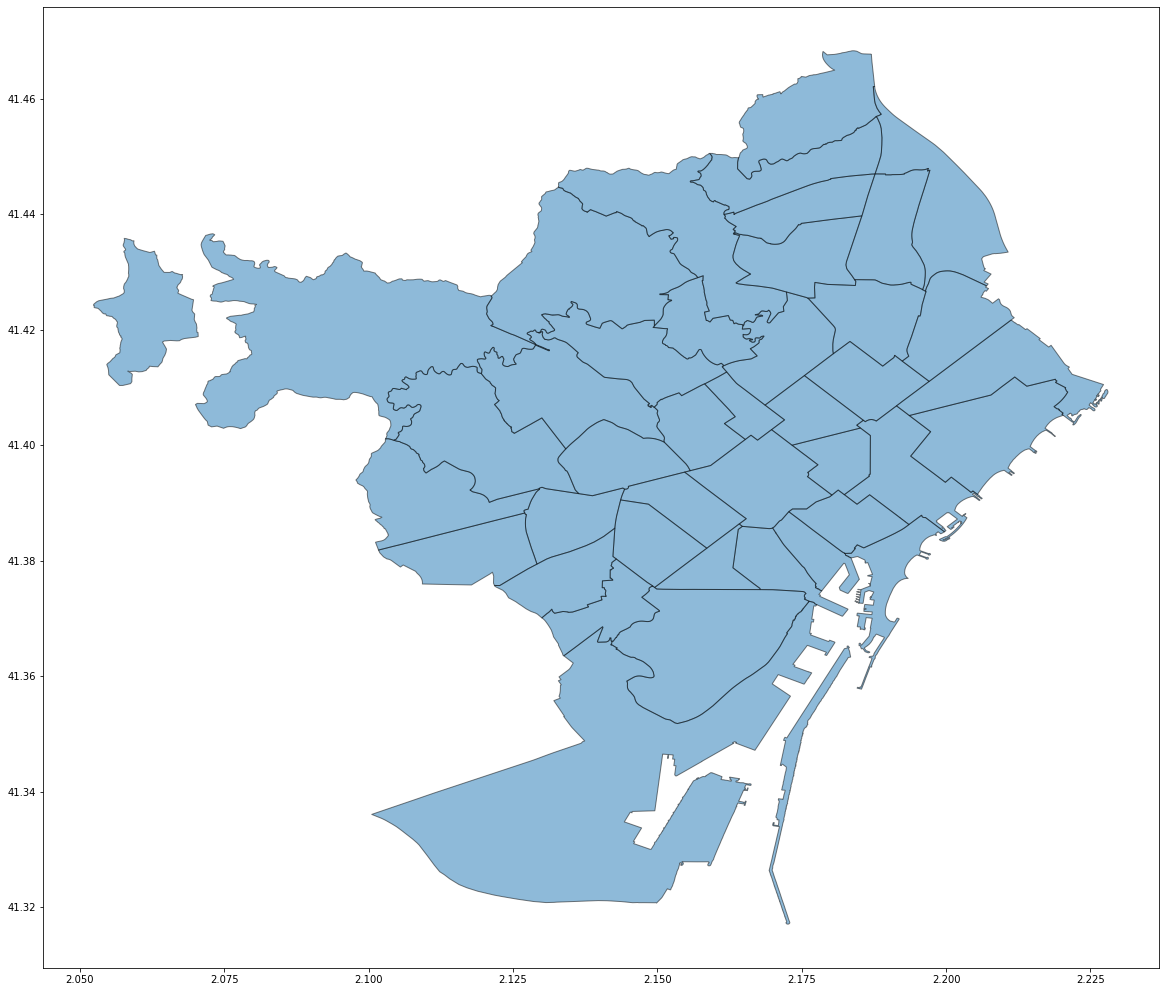

In [9]:
Nhoods.plot(alpha=0.5,figsize=(20,60),edgecolor='black')

In [10]:
Nhoods.head()

,ID_ANNEX,ANNEXDESCR,ID_TEMA,TEMA_DESCR,ID_CONJUNT,CONJ_DESCR,ID_SUBCONJ,SCONJ_DESC,ID_ELEMENT,ELEM_DESCR,...,ESTIL_ID,ESTIL_QGIS,VALOR1QGIS,VALOR2QGIS,COL_FARCIT,FCOL_DESCR,FHEX_COLOR,COL_DESCR,HEX_COLOR7,geometry
0,01,Grup - I,0104,Unitats Administratives,010417,Gran barri,01041701,Gran barri,0104170101,Límits gran barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#E66900,"POLYGON ((2.13747 41.39144, 2.13877 41.39124, ..."
1,01,Grup - I,0104,Unitats Administratives,010417,Gran barri,01041701,Gran barri,0104170101,Límits gran barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#E66900,"POLYGON ((2.12914 41.37943, 2.12915 41.37939, ..."
2,01,Grup - I,0104,Unitats Administratives,010417,Gran barri,01041701,Gran barri,0104170101,Límits gran barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#E66900,"POLYGON ((2.10342 41.40110, 2.10352 41.40109, ..."
3,01,Grup - I,0104,Unitats Administratives,010417,Gran barri,01041701,Gran barri,0104170101,Límits gran barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#E66900,"MULTIPOLYGON (((2.07313 41.43522, 2.07319 41.4..."
4,01,Grup - I,0104,Unitats Administratives,010417,Gran barri,01041701,Gran barri,0104170101,Límits gran barri,...,0,Sòlid,0,0,41,NULL,#E66900,NULL,#E66900,"POLYGON ((2.11685 41.41352, 2.11706 41.41347, ..."


In [11]:
Nhoods.columns

Index(['ID_ANNEX', 'ANNEXDESCR', 'ID_TEMA', 'TEMA_DESCR', 'ID_CONJUNT',
       'CONJ_DESCR', 'ID_SUBCONJ', 'SCONJ_DESC', 'ID_ELEMENT', 'ELEM_DESCR',
       'NIVELL', 'NDESCR_CA', 'NDESCR_ES', 'NDESCR_EN', 'TERME', 'DISTRICTE',
       'BARRI', 'AEB', 'SEC_CENS', 'GRANBARRI', 'ZUA', 'AREA_I', 'LITERAL',
       'PERIMETRE', 'AREA', 'ORD_REPRES', 'CODI_UA', 'TIPUS_UA', 'NOM', 'WEB1',
       'WEB2', 'WEB3', 'DOCUMENTA', 'RANGESCALA', 'TIPUS_POL', 'GRUIX_ID',
       'GRUIXDIMEN', 'ESTIL_ID', 'ESTIL_QGIS', 'VALOR1QGIS', 'VALOR2QGIS',
       'COL_FARCIT', 'FCOL_DESCR', 'FHEX_COLOR', 'COL_DESCR', 'HEX_COLOR7',
       'geometry'],
      dtype='object')

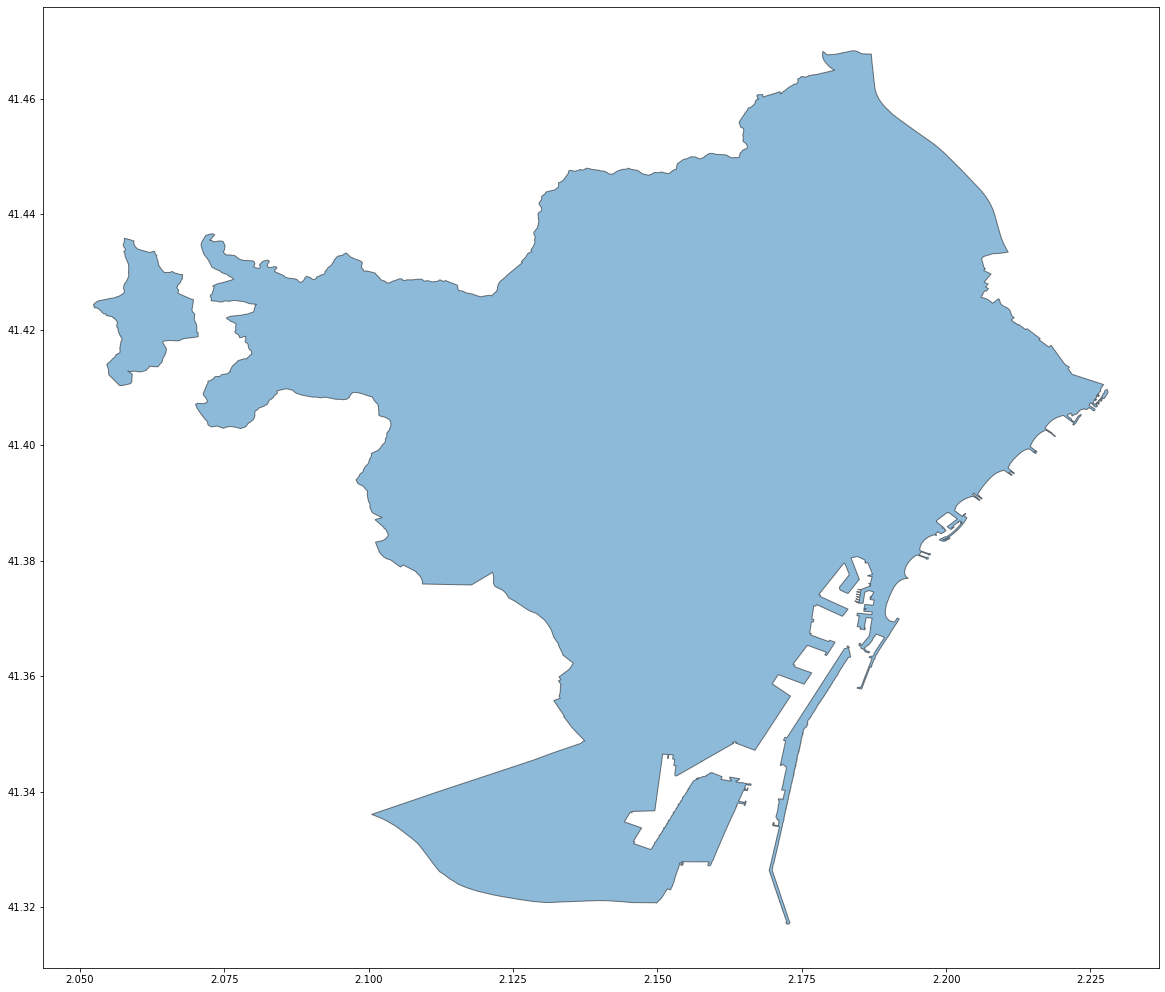

In [12]:
TO_boundary = Nhoods.dissolve(by='ID_CONJUNT')
TO_boundary = TO_boundary[['geometry']] # keep only 'geometry' 
TO_boundary.plot(alpha=0.5,edgecolor='black',figsize=(20,60))

In [13]:
def haversine(coord1, coord2):
    # Coordinates in decimal degrees (e.g. 43.60, -79.49)
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371000  # radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)    
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)    
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2    
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1 - a))    
    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers    meters = round(meters)
    km = round(km, 3)
    #print(f"Distance: {meters} m")
    #print(f"Distance: {km} km")
    return meters

In [14]:
xmin,ymin,xmax,ymax = Nhoods.total_bounds # lat-long of 2 corners#East-West extent of Toronto = 42193 metres
EW = haversine((xmin,ymin),(xmax,ymin))# North-South extent of Toronto = 30519 metres
NS = haversine((xmin,ymin),(xmin,ymax))# diamter of each hexagon in the grid = 900 metres
d = 300# horizontal width of hexagon = w = d* sin(60)
w = d*np.sin(np.pi/3)# Approximate number of hexagons per row = EW/w 
n_cols = int(EW/w)+1# Approximate number of hexagons per column = NS/d
n_rows = int(NS/d)+ 1

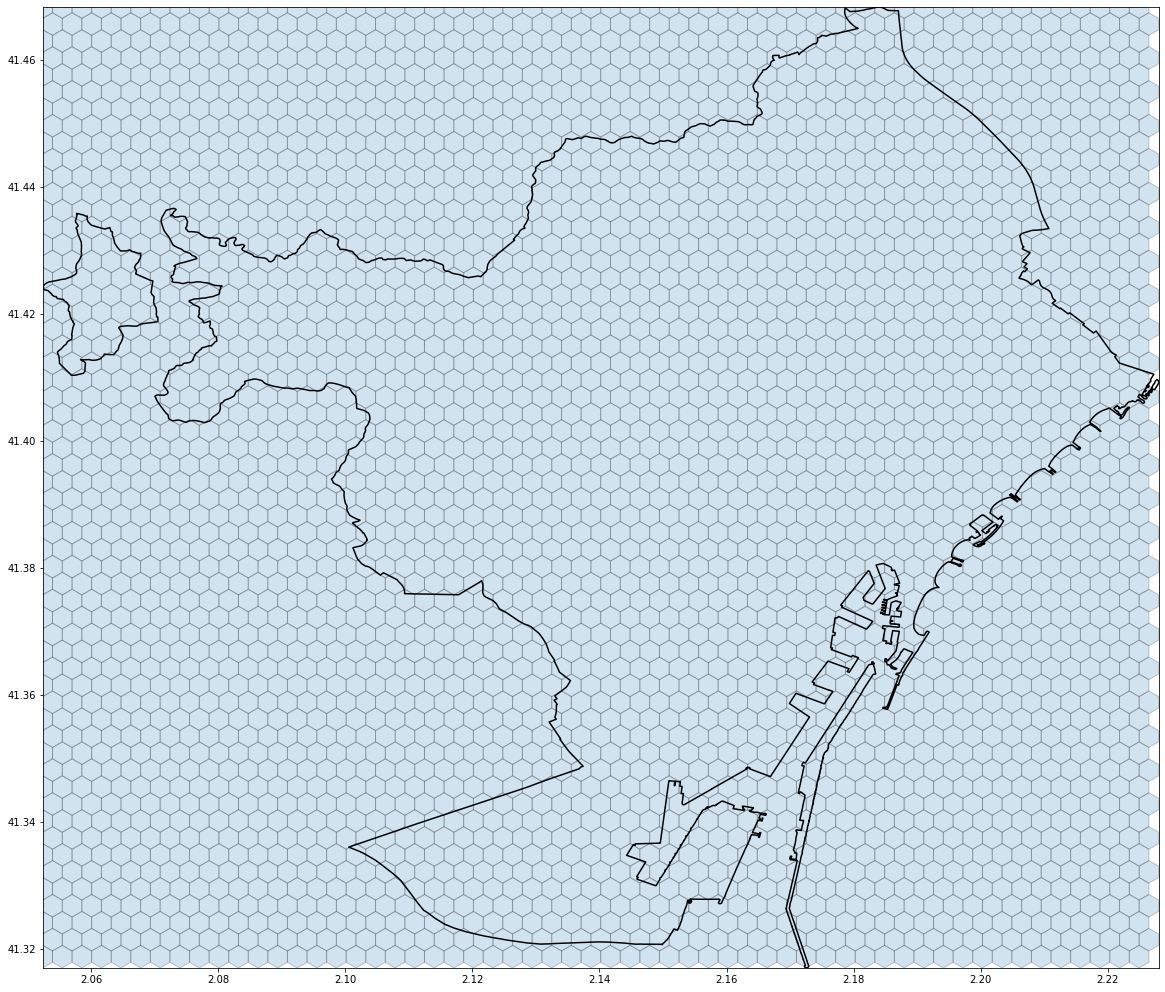

In [16]:
from matplotlib.patches import RegularPolygon
from matplotlib import pyplot as plt

ax = TO_boundary.boundary.plot(edgecolor='black',figsize=(20,60))

w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon

array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
        ax.add_patch(hexes)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

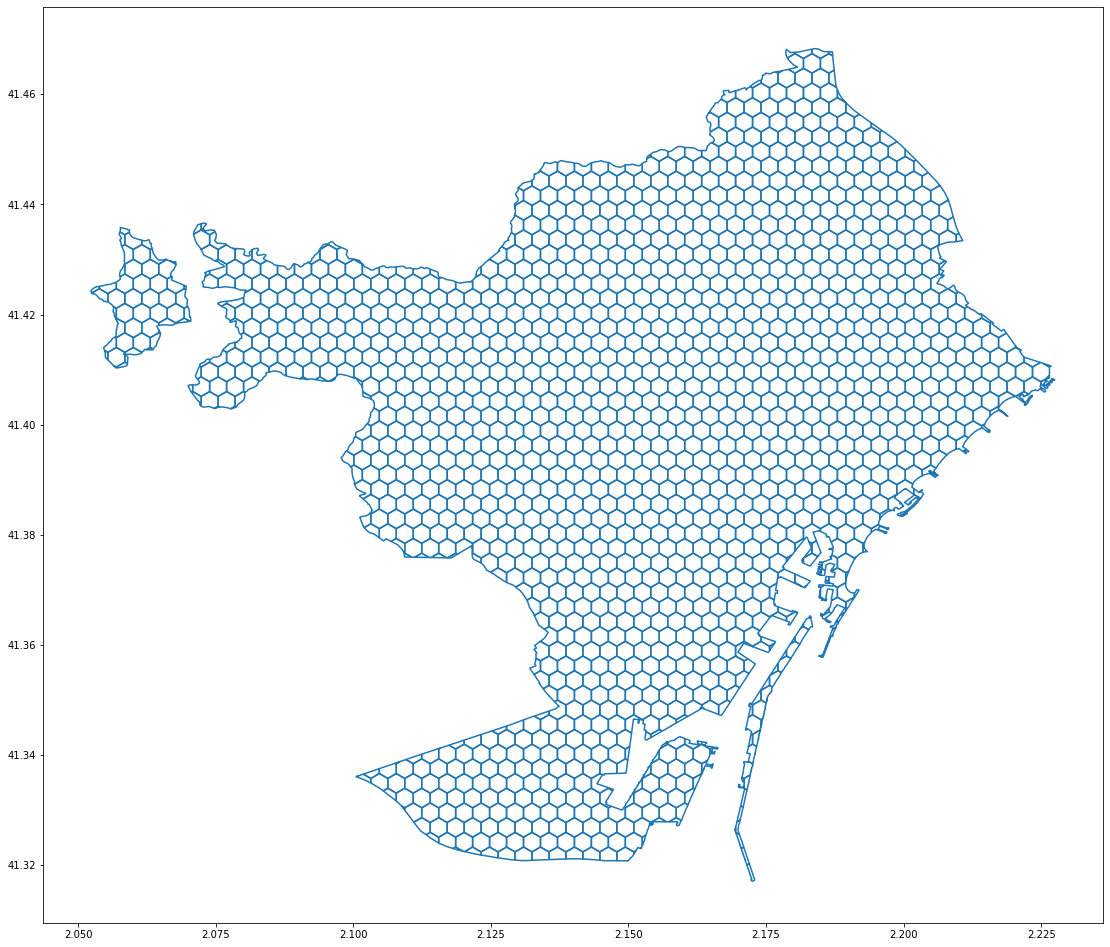

In [17]:
hex_grid = gpd.GeoDataFrame({'geometry':array_of_hexes},crs={'init':'epsg:4326'})
TO_hex = gpd.overlay(hex_grid,TO_boundary)
TO_hex = gpd.GeoDataFrame(TO_hex,geometry='geometry')
TO_hex.boundary.plot(figsize=(19,19))

In [90]:
TO_hex.to_file('HEX_BCN.shp')

In [164]:
gdf = pd.read_csv('ret_ds_CLEAN.csv')

In [165]:
map_data = gpd.read_file('HEX_BCN.geojson')

In [ ]:
import folium

m = folium.Map([41.3887901,2.1589899], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(map_data).add_to(m)
folium.LatLngPopup().add_to(m)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=2,
                        weight=1).add_to(m)
gdf.apply(plotDot, axis = 1)
m

<img src="all_p_hexa.png">

In [18]:
map_data.head()

,FID,geometry
0,0,"MULTIPOLYGON (((2.18026 41.46764, 2.18026 41.4..."
1,1,"MULTIPOLYGON (((2.18335 41.46821, 2.18335 41.4..."
2,2,"MULTIPOLYGON (((2.18643 41.46774, 2.18643 41.4..."
3,3,"MULTIPOLYGON (((2.18712 41.46701, 2.18643 41.4..."
4,4,"MULTIPOLYGON (((2.17792 41.46428, 2.17718 41.4..."


# Ubicación de los puntos dentro de los hexagonos:  <a name="t11"></a>

In [59]:
points_inside = gpd.sjoin(gdf, map_data[['FID', 'geometry']], op='within')
print (points_inside.head())

           id                 title number        street  id_sec  id_subsec  \
0     83969.0         Garces Taller     78   CL ROCAFORT       9         12   
88    84233.0       A.Alsina Taller    139   CL CALABRIA       9         12   
159   76483.0             R. Garcia     51  CL DIPUTACIO       9         12   
1398  83964.0  Lunch & Catering Bar     72   CL ROCAFORT       2         40   
1601  74970.0     El Racó D'En Xavi     42  CL DIPUTACIO       2         40   

     cod_sec cod_sub           sector         x          y       lon  \
0       tran    tall  taller mecánico  429313.0  4581410.0  2.153513   
88      tran    tall  taller mecánico  429222.0  4581667.0  2.152395   
159     tran    tall  taller mecánico  429280.0  4581506.0  2.153107   
1398    host     bar   bares de copas  429327.0  4581395.0  2.153682   
1601    host     bar   bares de copas  429184.0  4581368.0  2.151975   

            lat                  geometry  index_right   FID  
0     41.379259  POINT (2.153

In [60]:
points_inside.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,index_right,FID
0,83969.0,Garces Taller,78,CL ROCAFORT,9,12,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.15351 41.37926),1097,1097
88,84233.0,A.Alsina Taller,139,CL CALABRIA,9,12,tran,tall,taller mecánico,429222.0,4581667.0,2.152395,41.381566,POINT (2.15239 41.38157),1097,1097
159,76483.0,R. Garcia,51,CL DIPUTACIO,9,12,tran,tall,taller mecánico,429280.0,4581506.0,2.153107,41.380121,POINT (2.15311 41.38012),1097,1097
1398,83964.0,Lunch & Catering Bar,72,CL ROCAFORT,2,40,host,bar,bares de copas,429327.0,4581395.0,2.153682,41.379125,POINT (2.15368 41.37913),1097,1097
1601,74970.0,El Racó D'En Xavi,42,CL DIPUTACIO,2,40,host,bar,bares de copas,429184.0,4581368.0,2.151975,41.378869,POINT (2.15198 41.37887),1097,1097


In [61]:
points_inside.shape

(79814, 16)

In [ ]:
points_inside['index_right'].unique()

In [62]:
points_inside.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,index_right,FID
0,83969.0,Garces Taller,78,CL ROCAFORT,9,12,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.15351 41.37926),1097,1097
88,84233.0,A.Alsina Taller,139,CL CALABRIA,9,12,tran,tall,taller mecánico,429222.0,4581667.0,2.152395,41.381566,POINT (2.15239 41.38157),1097,1097
159,76483.0,R. Garcia,51,CL DIPUTACIO,9,12,tran,tall,taller mecánico,429280.0,4581506.0,2.153107,41.380121,POINT (2.15311 41.38012),1097,1097
1398,83964.0,Lunch & Catering Bar,72,CL ROCAFORT,2,40,host,bar,bares de copas,429327.0,4581395.0,2.153682,41.379125,POINT (2.15368 41.37913),1097,1097
1601,74970.0,El Racó D'En Xavi,42,CL DIPUTACIO,2,40,host,bar,bares de copas,429184.0,4581368.0,2.151975,41.378869,POINT (2.15198 41.37887),1097,1097


In [ ]:
points_inside.to_csv('points_inside_HEX.csv', index=False)

---

# Creación del dataset definitivo  <a name="t12"></a>

¿Qué es necesario para crear el dataset definitivo?:  
  
* En primer lugar, la base de datos de Barcelona en `CSV`.  

* En segundo, un listado de nombres de cadenas y franquicias para hacer el matching por nombre y añadir una columna más a la base de datos.

* En tercero, enriquecer el dataset usando ciertas técnicas comentadas en el [artículo][doc] una herramienta de Web Scraping en la pagina de Google Maps.
[doc]: https://towardsdatascience.com/getting-insights-about-businesses-and-locations-from-google-maps-3f8a5739059a

Los siguientes pasos a seguir serían:

 1. Ver si con la API de Google Maps podemos descargar los polígonos de áreas de interés.
 2. Si no se puede, ver cuántos POI (Points of Interest, es decir, comercios) podemos descargar sin que salten las alarmas.
 3. En caso de no poder extraer las áreas de interés, crearlas a mano con QGIS (es bastante sencillo y no hay muchas en Barcelona).
 4. Estudiar qué hay dentro de las áreas de interés mediante un cruce con la base de datos de EIXOS.
 5. Crear una malla de cuadrados/hexágonos de 100x100m, 200x200m o lo que creamos conveniente.
 6. Cruzar los datos de EIXOS y de áreas de interés con la malla del punto 5 (en el caso de los datos de Google, o bien % de superficie del cuadrado/hexágono cubierta o una simple dummy con 1 si hay área de interés y 0 si no hay).
 7. Testear distintas metodologías de predicción usando el campo creado en el punto 6 como target variable. Partimos dataset en 80% para training, 20% para testing, etc.

In [167]:
gdf = pd.read_csv('ret_ds_CLEAN.csv')
p_in = pd.read_csv('points_inside_CLEAN.csv',usecols=['id','polygon_id','Name'])
pol_hex = pd.read_csv('points_inside_HEX.csv', usecols=['id','FID'] )
frn_ds = pd.read_csv('frn_ds_CLEAN.csv')

`merge` de las ~23,000 muestras con el dataset original de 80,000 registros.

In [171]:
tempo = pd.merge(gdf, p_in, on='id', how='outer')

In [172]:
tempo.isnull().sum()

id                0
title             0
number            0
street            0
id_sec            0
id_subsec         0
cod_sec           0
cod_sub           0
sector            0
x                 0
y                 0
lon               0
lat               0
geometry          0
polygon_id    56716
Name          56716
dtype: int64

In [173]:
nan_rows = tempo[tempo.isnull().any(1)]
nan_rows.tail()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,Name
80055,731434.0,Todotaxi,93,CL DE LLULL,5,140,other,taxi,taxi,432825.0000,4583275.000,2.195302,41.396358,POINT (2.195302415 41.39635751),NaN,NaN
80056,732722.0,Fuber taxi,131,CL RAMÓN TURRÓ,5,140,other,taxi,taxi,433071.7216,4583313.355,2.198249,41.396724,POINT (2.19824925 41.39672354),NaN,NaN
80057,739672.0,Taxi a punto,54,CL ALMOGAVERS,5,140,other,taxi,taxi,431987.0000,4582937.000,2.185317,41.393243,POINT (2.185316967 41.39324276),NaN,NaN
80059,733224.0,EQ Esteve,17-19,CL CARACAS,5,541,other,ticinve,centro de I+D,433427.5929,4588337.080,2.201953,41.442000,POINT (2.201952647 41.44200031),NaN,NaN
80061,733298.0,Cesva Instruments SL,6,CL MARACAIBO,5,568,other,inelec,fabricación de aparatos electrodomésticos,433579.6932,4588264.541,2.203781,41.441360,POINT (2.203781199 41.44135958),NaN,NaN


Los valores NaN en la columna **Name** son los registros que no estan dentro de los polígonos.

In [174]:
tempo.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,Name
0,83969.0,Garces Taller,78,CL ROCAFORT,9,12,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.153512887 41.37925891),NaN,NaN
1,117499.0,Anton Solé,10,PZ NAVAS,9,12,tran,tall,taller mecánico,429739.0,4580810.0,2.158677,41.373892,POINT (2.158676542 41.37389224),NaN,NaN
2,117503.0,Auto.Carburación,1,CL TEODOR BONAPLATA,9,12,tran,tall,taller mecánico,429786.0,4580886.0,2.159230,41.374581,POINT (2.159229711 41.37458085),NaN,NaN
3,117511.0,"M.F, Flomart",30,PS MONTJUIC,9,12,tran,tall,taller mecánico,430800.0,4580634.0,2.171383,41.372399,POINT (2.171382973 41.37239903),NaN,NaN
4,117515.0,F.Espunes,68,PS MONTJUIC,9,12,tran,tall,taller mecánico,430491.0,4580569.0,2.167696,41.371787,POINT (2.167695814 41.37178696),NaN,NaN


In [175]:
tempo['Name'].shape

(80062,)

In [176]:
tempo['polygon_id'].fillna(115,inplace =True)

In [177]:
tempo.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,Name
0,83969.0,Garces Taller,78,CL ROCAFORT,9,12,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.153512887 41.37925891),115.0,NaN
1,117499.0,Anton Solé,10,PZ NAVAS,9,12,tran,tall,taller mecánico,429739.0,4580810.0,2.158677,41.373892,POINT (2.158676542 41.37389224),115.0,NaN
2,117503.0,Auto.Carburación,1,CL TEODOR BONAPLATA,9,12,tran,tall,taller mecánico,429786.0,4580886.0,2.159230,41.374581,POINT (2.159229711 41.37458085),115.0,NaN
3,117511.0,"M.F, Flomart",30,PS MONTJUIC,9,12,tran,tall,taller mecánico,430800.0,4580634.0,2.171383,41.372399,POINT (2.171382973 41.37239903),115.0,NaN
4,117515.0,F.Espunes,68,PS MONTJUIC,9,12,tran,tall,taller mecánico,430491.0,4580569.0,2.167696,41.371787,POINT (2.167695814 41.37178696),115.0,NaN


In [178]:
tempo.shape

(80062, 16)

## 2. Matching de base de datos y grandes franquicias  <a name="st7"></a>

In [179]:
frn_ds.head()

,CADENA,VALUE
0,Accezorize,1.0
1,Adidas,1.0
2,Adolfo Dominguez,1.0
3,Agua Viva,1.0
4,Ale -Hop,1.0


Demostración de la nueva columna ***Name*** agregada:

In [180]:
is_there = tempo.loc[:, 'title'] == 'Zara'
df_adi = tempo.loc[is_there]
df_adi.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,Name
7983,170494.0,Zara,58,CL PELAI,6,8,pers,moda,tienda de ropa,430639.0,4582079.0,2.169292,41.385400,POINT (2.169292485 41.38539984),115.0,NaN
8608,17378.0,Zara,34,AV PORTAL DE L'ANGEL,6,8,pers,moda,tienda de ropa,430896.0,4582180.0,2.172354,41.386332,POINT (2.172354441 41.38633165),115.0,NaN
8624,17415.0,Zara,15,AV PORTAL DE L'ANGEL,6,8,pers,moda,tienda de ropa,430957.0,4582078.0,2.173096,41.385418,POINT (2.173095585 41.38541821),95.0,aoi_96
8968,73852.0,Zara,67,RB CATALUNYA,6,8,pers,moda,tienda de ropa,430107.0,4582741.0,2.162854,41.391316,POINT (2.162853847 41.39131619),9.0,aoi_10
9327,355882.0,Zara,5,AV DIAGONAL,6,8,pers,moda,tienda de ropa,434581.0,4584781.0,2.216143,41.410067,POINT (2.216143427 41.41006654),85.0,aoi_86


In [181]:
df_adi.shape

(11, 16)

In [182]:
frn_ds.rename(columns={'CADENA':'title'}, inplace=True)

In [183]:
frn_ds.head()

,title,VALUE
0,Accezorize,1.0
1,Adidas,1.0
2,Adolfo Dominguez,1.0
3,Agua Viva,1.0
4,Ale -Hop,1.0


## 3. Matching de anterior dataset y coincidencias de polygonos de Areas De Interes  <a name="st8"></a>

`merge` del dataset `tempo` que contrasta los registros con los nombres de los polígonos a los que pertenecen y el dataset de franquicias.

In [184]:
tempa = pd.merge(tempo, frn_ds, on = 'title', how='outer')
tempa.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,Name,VALUE
0,83969.0,Garces Taller,78,CL ROCAFORT,9.0,12.0,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.153512887 41.37925891),115.0,NaN,NaN
1,117499.0,Anton Solé,10,PZ NAVAS,9.0,12.0,tran,tall,taller mecánico,429739.0,4580810.0,2.158677,41.373892,POINT (2.158676542 41.37389224),115.0,NaN,NaN
2,117503.0,Auto.Carburación,1,CL TEODOR BONAPLATA,9.0,12.0,tran,tall,taller mecánico,429786.0,4580886.0,2.159230,41.374581,POINT (2.159229711 41.37458085),115.0,NaN,NaN
3,117511.0,"M.F, Flomart",30,PS MONTJUIC,9.0,12.0,tran,tall,taller mecánico,430800.0,4580634.0,2.171383,41.372399,POINT (2.171382973 41.37239903),115.0,NaN,NaN
4,117515.0,F.Espunes,68,PS MONTJUIC,9.0,12.0,tran,tall,taller mecánico,430491.0,4580569.0,2.167696,41.371787,POINT (2.167695814 41.37178696),115.0,NaN,NaN


In [185]:
tempa.isnull().sum()

id               23
title             0
number           23
street           23
id_sec           23
id_subsec        23
cod_sec          23
cod_sub          23
sector           23
x                23
y                23
lon              23
lat              23
geometry         23
polygon_id       23
Name          56739
VALUE         77725
dtype: int64

In [186]:
nan_rows = tempa[tempa.id.isnull()]

In [187]:
nan_rows

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,Name,VALUE
80062,NaN,Anna Mora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80063,NaN,Bon aliment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80064,NaN,Bottega Venetta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80065,NaN,Caramelo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80066,NaN,Carmina Shoemaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80067,NaN,Carrera Y Carrera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80068,NaN,Dirk Bikkembers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80069,NaN,Double Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80070,NaN,G-Star Raw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
80071,NaN,Karen Millen London,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [188]:
len(nan_rows)

23

In [189]:
tempa.drop(tempa[tempa.id.isnull()].index, inplace = True)

In [190]:
tempa.shape

(80062, 17)

In [191]:
tempa.rename(columns={'Name':'polygon','VALUE':'franchise'}, inplace=True)

Demostración de las nuevas columnas ***Name -> polygon***, ***VALUE -> franchise*** agregadas:

In [192]:
is_there = tempa.loc[:, 'title'] == 'Zara'
df_adi = tempa.loc[is_there]
df_adi

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,polygon,franchise
20028,170494.0,Zara,58,CL PELAI,6.0,8.0,pers,moda,tienda de ropa,430639.0000,4582079.000,2.169292,41.385400,POINT (2.169292485 41.38539984),115.0,NaN,1.0
20029,17378.0,Zara,34,AV PORTAL DE L'ANGEL,6.0,8.0,pers,moda,tienda de ropa,430896.0000,4582180.000,2.172354,41.386332,POINT (2.172354441 41.38633165),115.0,NaN,1.0
20030,17415.0,Zara,15,AV PORTAL DE L'ANGEL,6.0,8.0,pers,moda,tienda de ropa,430957.0000,4582078.000,2.173096,41.385418,POINT (2.173095585 41.38541821),95.0,aoi_96,1.0
20031,73852.0,Zara,67,RB CATALUNYA,6.0,8.0,pers,moda,tienda de ropa,430107.0000,4582741.000,2.162854,41.391316,POINT (2.162853847 41.39131619),9.0,aoi_10,1.0
20032,355882.0,Zara,5,AV DIAGONAL,6.0,8.0,pers,moda,tienda de ropa,434581.0000,4584781.000,2.216143,41.410067,POINT (2.216143427 41.41006654),85.0,aoi_86,1.0
20033,315106.0,Zara,16,PS GRACIA,6.0,8.0,pers,moda,tienda de ropa,430621.0000,4582535.000,2.169025,41.389505,POINT (2.16902497 41.38950534),95.0,aoi_96,1.0
20034,912261.0,Zara,2,CL POTOSI,6.0,8.0,pers,moda,tienda de ropa,433100.7770,4588178.218,2.198058,41.440542,POINT (2.1980584 41.4405423),115.0,NaN,1.0
20035,912585.0,Zara,557,AV DIAGONAL,6.0,8.0,pers,moda,tienda de ropa,427646.8332,4582529.920,2.133455,41.389197,POINT (2.1334553 41.3891974),0.0,aoi_1,1.0
20036,937344.0,Zara,218,AV DIAGONAL,6.0,8.0,pers,moda,tienda de ropa,432465.1900,4584269.154,2.190888,41.405281,POINT (2.1908877 41.4052814),32.0,aoi_33,1.0
20037,937593.0,Zara,2,CL POTOSI,6.0,8.0,pers,moda,tienda de ropa,433100.7770,4588178.218,2.198058,41.440542,POINT (2.1980584 41.4405423),115.0,NaN,1.0


## 4. Matching de anterior dataset y coincidencias en polygonos Hexagonales  <a name="st9"></a>

In [193]:
tempu = pd.merge(tempa, pol_hex, on = 'id', how='outer')
tempu.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,polygon,franchise,FID
0,83969.0,Garces Taller,78,CL ROCAFORT,9.0,12.0,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.153512887 41.37925891),115.0,NaN,NaN,1097.0
1,117499.0,Anton Solé,10,PZ NAVAS,9.0,12.0,tran,tall,taller mecánico,429739.0,4580810.0,2.158677,41.373892,POINT (2.158676542 41.37389224),115.0,NaN,NaN,1158.0
2,117503.0,Auto.Carburación,1,CL TEODOR BONAPLATA,9.0,12.0,tran,tall,taller mecánico,429786.0,4580886.0,2.159230,41.374581,POINT (2.159229711 41.37458085),115.0,NaN,NaN,1158.0
3,117511.0,"M.F, Flomart",30,PS MONTJUIC,9.0,12.0,tran,tall,taller mecánico,430800.0,4580634.0,2.171383,41.372399,POINT (2.171382973 41.37239903),115.0,NaN,NaN,1185.0
4,117515.0,F.Espunes,68,PS MONTJUIC,9.0,12.0,tran,tall,taller mecánico,430491.0,4580569.0,2.167696,41.371787,POINT (2.167695814 41.37178696),115.0,NaN,NaN,1183.0


In [194]:
tempu.shape

(80062, 18)

In [195]:
tempu.isnull().sum()

id                0
title             0
number            0
street            0
id_sec            0
id_subsec         0
cod_sec           0
cod_sub           0
sector            0
x                 0
y                 0
lon               0
lat               0
geometry          0
polygon_id        0
polygon       56716
franchise     77725
FID             248
dtype: int64

In [196]:
tempu['franchise'].fillna(0,inplace =True)

In [197]:
tempu['in_poly'] = tempu['polygon']

In [198]:
tempu['in_poly'].fillna(0,inplace =True)

In [199]:
#covirtiendo a categorica columna in_poly
tempu.in_poly.loc[tempu.in_poly != 0] = "1"

In [200]:
tempu.isnull().sum()

id                0
title             0
number            0
street            0
id_sec            0
id_subsec         0
cod_sec           0
cod_sub           0
sector            0
x                 0
y                 0
lon               0
lat               0
geometry          0
polygon_id        0
polygon       56716
franchise         0
FID             248
in_poly           0
dtype: int64

In [201]:
tempu['polygon'].fillna('out',inplace =True)

In [202]:
tempu['FID'].fillna(0,inplace =True)

In [203]:
tempu.isnull().sum()

id            0
title         0
number        0
street        0
id_sec        0
id_subsec     0
cod_sec       0
cod_sub       0
sector        0
x             0
y             0
lon           0
lat           0
geometry      0
polygon_id    0
polygon       0
franchise     0
FID           0
in_poly       0
dtype: int64

In [204]:
tempu.shape

(80062, 19)

In [205]:
tempu.columns

Index(['id', 'title', 'number', 'street', 'id_sec', 'id_subsec', 'cod_sec',
       'cod_sub', 'sector', 'x', 'y', 'lon', 'lat', 'geometry', 'polygon_id',
       'polygon', 'franchise', 'FID', 'in_poly'],
      dtype='object')

In [206]:
tempu.rename(columns={'FID':'in_hex'}, inplace=True)

In [207]:
tempu.to_csv('df_sup.csv', index=False)

Explicar que hasta aqui ya se tiene un dataset robusto y lo que quedaria seria tratar de enriquecerlo mas con una herramienta de webscraping y el sitio de google maps.

---

# Adicional: Uso de herramienta chromedriver para realizar webscraping  <a name="t13"></a>

In [54]:
from selenium import webdriver

In [55]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementNotInteractableException, ElementClickInterceptedException

In [84]:
from tqdm import tqdm_notebook as tqdmn

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
import folium

In [35]:
import time, re

In [62]:
# Make sure to supply the path to where you put the chromedriver.exe file. Use \\ instead of \ :
driver = webdriver.Chrome("C:\\webdrivers\chromedriver.exe")

# This is the list where we'll capture the competitors' names and addresses
competition = []

# The name and location of the initial print shop that will go into the search URL
starting_business = 'Sfera'
city = 'Barcelona'
url = 'https://www.google.com/maps/search/' + starting_business + ' ' + city

# Opening the search URL. You'll notice a chrome window opening :
driver.get(url)

# Waiting for the name of the business to load and be visible :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))

# Clicking on the business category :
driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').click()

# Waiting for the results to appear :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))
        
# We repeat the code below 5 times (if we arrive at the end of the navgation list the loop breaks on its own) :
for i in tqdmn(range(5), leave=False, desc='1. Rounding the competition' ) :
    
    # Waiting for the results to appear :
    WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))

    # Capturing the names and addresses of the competitors and adding them to our list 'competition' :
    result_names = [i.text for i in driver.find_elements_by_css_selector('h3[class=section-result-title]')]
    result_addresses = [i.text for i in driver.find_elements_by_css_selector('span[class=section-result-location]')] 
    
    for name, address in zip(result_names, result_addresses) :
        competition.append(name + ' ' + address)
        
    # Waiting for the 'Next' button to be visible and then click it (if it's not clickable, we break the for loop) :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='n7lv7yjyC35__section-pagination-button-next']"))).click()
    except ElementClickInterceptedException :
        break
        
    # Waiting 5 seconds before looping (otherwise we get the error ElementClickInterceptedException). If you get the
    #exception, make it wait for a little longer than 5 seconds :
    time.sleep(5)

# We want to remove any '/' character in the names and addresses in the competition list (because they'll break URLs) :
competition = [i.replace('/', ' ') for i in competition]

# These are the empty lists we will populate with the extracted data in the 2nd phase :
full_name = []
rating = []
total_ratings = []
business_cat = []
address = []
phone = []
website = []
lat = []
long = []
    
# Here's the big loop iterating over the competiton list :
for business in tqdmn(competition, leave=False, desc='2. Extracting the data') :
    
    # URL making :
    url = 'https://www.google.com/maps/search/' + business
    driver.get(url)

    # Waiting for the name of the business to load and be visible. If it fails, skip to next business in competition list :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))
    except (NoSuchElementException, TimeoutException) as e :
        continue
        
    # Extracting the data and putting it into the empty lists we defined earlier :
    try:
        full_name.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]').text)
    except NoSuchElementException :
        full_name.append(np.nan)

    try:
        rating.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[1]/span/span').text)
    except NoSuchElementException :
        rating.append(np.nan)

    try:
        total_ratings.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[1]/span[2]/span[1]/button').text)
    except NoSuchElementException:
        total_ratings.append(np.nan)

    try:
        business_cat.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').text)
    except NoSuchElementException:
        business_cat.append(np.nan)
    
    try:#falla
        address.append(driver.find_element_by_css_selector('div[data-tooltip="Copiar la dirección"]').text)
    except NoSuchElementException :
        address.append(np.nan)
    
    try:
        phone.append(driver.find_element_by_css_selector('div[data-tooltip="Copiar el número de teléfono"]').text)
    except NoSuchElementException :
        phone.append(np.nan)

    try:
        website.append(driver.find_element_by_css_selector('div[data-tooltip="Abrir el sitio web"]').text)
    except NoSuchElementException :
        website.append(np.nan)
    
    try:
        coordinates = driver.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content')
        coordinates = coordinates.split('?center=')[1].split('&zoom=')[0].split('%2C')
        lat.append(coordinates[0])
        long.append(coordinates[1])
    except NoSuchElementException:
        lat.append(np.nan)
        long.append(np.nan)

# Closing the Chrome window
driver.close()

In [63]:
PS = pd.DataFrame(data={'full_name':full_name, 'rating':rating, 'total_ratings':total_ratings, 'business_category':business_cat, 'address':address, 'phone':phone, 'website':website, 'latitude':lat, 'longitude':long})

In [64]:
PS.to_csv('print_shops_test.csv', index=False)

In [65]:
PS = pd.read_csv('print_shops_test.csv')

In [ ]:
from IPython.display import IFrame

PS_map = folium.Map( [41.3887901, 2.1589899], zoom_start=13, tiles='CartoDB positron' )

for latitude, longitude, full_name, address, phone, website, rating, total_rating in zip(PS.latitude, PS.longitude, PS.full_name, PS.address, PS.phone, PS.website, PS.rating, PS.total_ratings):
    popup = '<strong>' + str(full_name) + '</strong><br><br><ul><li>' + str(address) + '</li><li>' + str(phone) + '</li><li>' + str(website) + '</li><li>Rating: ' + str(rating) + ' (Total of ' + str(total_rating) + ' reviews)'
    folium.Marker( [latitude, longitude], 
                   icon=folium.CustomIcon( icon_image='https://i.imgur.com/CYx04oC.png', icon_size=(10,10) ), popup=popup).add_to(PS_map)

PS_map.save('PS_map.html')
IFrame(src='PS_map.html', width='100%', height=500)

<img src="fol_2.png">

In [67]:
PS.shape

(20, 9)

In [306]:
PS.head()

,full_name,rating,total_ratings,business_category,address,phone,website,latitude,longitude
0,eseOese,"4,1",(41),Tienda de ropa de mujer,"L'Illa Diagonal, local 2.10, Avinguda Diagonal...",934 10 96 56,eseoese.com,41.389665,2.135100
1,BROWNIE,"4,1",(54),Tienda de ropa de mujer,"Avinguda Diagonal, 577, 08029 Barcelona\nSe en...",934 10 90 78,browniespain.com,41.389465,2.134888
2,Sfera,"3,9",(1.187),Tienda de ropa,"Avinguda Diagonal, 545, 08028 Barcelona\nSe en...",934 94 17 58,sfera.com,41.389954,2.136816
3,System Action,"3,6",(42),Tienda de ropa,"C.C L'illa, Avinguda Diagonal, 557, 08029 Barc...",934 10 18 74,systemaction.es,41.389891,2.136364
4,Dr. Bloom,"3,8",(5),Tienda de ropa de mujer,"Avinguda Diagonal, 557, 215, 08029 Barcelona\n...",934 19 61 52,drbloom.es,41.389482,2.134775


In [69]:
# Make sure to supply the path to where you put the chromedriver.exe file. Use \\ instead of \ :
driver = webdriver.Chrome("C:\\webdrivers\chromedriver.exe")

# This is the list where we'll capture the historical landmarks (names and addresses)
landmarks = []

# The first search we'll do for 'barcelona supermercado hospitales'
url = 'https://www.google.com/maps/search/barcelona supermercado hospitales'

# Opening the search URL. You'll notice a chrome window opening :
driver.get(url)
        
# We repeat the code below 3 times if we arrive at the end of the navgation list the loop breaks on its own) :
for i in tqdmn(range(2), leave=False, desc='1. Rounding the landmarks' ) :
    
    # Waiting for the results to appear :
    WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))

    # Capturing the names of the competitors and adding it to our historical landmarks' :
    result_names = [i.text for i in driver.find_elements_by_css_selector('h3[class=section-result-title]')]
    result_addresses = [i.text for i in driver.find_elements_by_css_selector('span[class=section-result-location]')] 
    
    for name, address in zip(result_names, result_addresses) :
        landmarks.append(name + ' ' + address)
        
    # Waiting for the 'Next' button to be visible and then click it. If it's not there anymore, break the loop :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='n7lv7yjyC35__section-pagination-button-next']"))).click()
    except ElementClickInterceptedException :
        break
        
    # Waiting 5 seconds before looping (otherwise we get the error ElementClickInterceptedException). If you get the
    #exception, make it wait for a little longer than 5 seconds :
    time.sleep(5)

# We want to remove any '/' character in the names and addresses in the landmarks list (because they'll break URLs) :
landmarks = [i.replace('/', ' ') for i in landmarks]

# These are the empty lists we will populate with the extracted data :
full_name = []
rating = []
total_ratings = []
landmark_cat = []
description = []
address = []
hours = []
lat = []
long = []
    
# Here's the big loop iterating over the landmarks list :
for landmark in tqdmn(landmarks, leave=False, desc='2. Extracting the data') :
    
    # URL making :
    url = 'https://www.google.com/maps/search/' + landmark
    driver.get(url)

    # Waiting for the name of the landmark to load and be visible. If it fails, skip to next one :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))
    except (NoSuchElementException, TimeoutException) as e :
        continue
        
    # Extracting the data and putting it into the empty lists we defined earlier :
    try:
        full_name.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]').text)
    except NoSuchElementException :
        full_name.append(np.nan)

    try:
        rating.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[1]/span/span').text)
    except NoSuchElementException :
        rating.append(np.nan)

    try:
        total_ratings.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[1]/span[2]/span[1]/button').text)
    except NoSuchElementException:
        total_ratings.append(np.nan)

    try:
        landmark_cat.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').text)
    except NoSuchElementException:
        landmark_cat.append(np.nan)
    
    try:
        description.append(driver.find_element_by_css_selector('div[class=section-editorial-quote]').text)
    except NoSuchElementException:
        description.append(np.nan
                          )
    try:
        address.append(driver.find_element_by_css_selector('div[data-tooltip="Copiar la dirección"]').text)
    except NoSuchElementException :
        address.append(np.nan)

    # Here we capture the popular hours for all 7 days starting with Sunday :
    try:
        hours.append([i.get_attribute('aria-label') for i in driver.find_elements_by_xpath("//*[contains(@aria-label, 'hora:')]")])
    except NoSuchElementException:
        hours.append(np.nan)
        
    try:
        coordinates = driver.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content')
        coordinates = coordinates.split('?center=')[1].split('&zoom=')[0].split('%2C')
        lat.append(coordinates[0])
        long.append(coordinates[1])
    except NoSuchElementException:
        lat.append(np.nan)
        long.append(np.nan)

# Closing the Chrome window
driver.close()

In [70]:
HL = pd.DataFrame(data={'full_name':full_name, 'rating':rating, 'total_ratings':total_ratings, 'landmark_category':landmark_cat, 'description':description, 'address':address, 'hours':hours})

In [72]:
HL.head()

,full_name,rating,total_ratings,landmark_category,description,address,hours
0,Supermercados Consum,"3,9",(260),Supermercado,Alimentación fresca y envasada y droguería en ...,"Avinguda de Vallcarca, 34, 08023 Barcelona","[Nivel de ocupación: % (hora: )., Nivel de oc..."
1,DIA,"2,7",(80),Supermercado,"Alimentación, bebidas, droguería y perfumería ...","Carrer de l'Hospital, 131, 08001 Barcelona","[Nivel de ocupación: 0 % (hora: 06)., Nivel de..."
2,Hospital de Barcelona,"4,2",(199),Hospital privado,NaN,"Avinguda Diagonal, 660, 08034 Barcelona",[]
3,Caprabo,"3,9",(68),Supermercado,Cadena de supermercados de proximidad con marc...,"Carrer de la Renaixença, 14, 08041 Barcelona",[]
4,Hospital Clínico Y Provincial de Barcelona,"3,8",,Hospital universitario,NaN,"Carrer de Villarroel, 170, 08036 Barcelona",[]


In [249]:
HL

,full_name,rating,total_ratings,landmark_category,description,address,hours
0,Supermercados Consum,"3,9",260.0,Supermercado,Alimentación fresca y envasada y droguería en ...,"Avinguda de Vallcarca, 34, 08023 Barcelona","['Nivel de ocupación: \xa0% (hora: ).', 'Nivel..."
1,DIA,"2,7",80.0,Supermercado,"Alimentación, bebidas, droguería y perfumería ...","Carrer de l'Hospital, 131, 08001 Barcelona","['Nivel de ocupación: 0\xa0% (hora: 06).', 'Ni..."
2,Hospital de Barcelona,"4,2",199.0,Hospital privado,NaN,"Avinguda Diagonal, 660, 08034 Barcelona",[]
3,Caprabo,"3,9",68.0,Supermercado,Cadena de supermercados de proximidad con marc...,"Carrer de la Renaixença, 14, 08041 Barcelona",[]
4,Hospital Clínico Y Provincial de Barcelona,"3,8",NaN,Hospital universitario,NaN,"Carrer de Villarroel, 170, 08036 Barcelona",[]
5,Caprabo,"3,4",180.0,Supermercado,Cadena de supermercados de proximidad con marc...,"Carrer de Còrsega, 301, 08008 Barcelona","['Nivel de ocupación: \xa0% (hora: ).', 'Nivel..."
6,Caprabo,"3,6",292.0,Supermercado,Cadena de supermercados de proximidad con marc...,"Av. del Jordà, 20, 08035 Barcelona","['Nivel de ocupación: \xa0% (hora: ).', 'Nivel..."
7,Condis,"3,8",153.0,Supermercado,Marca de productos propia en cadena de superme...,"Carrer de Trias i Giró, 15, 19, 08034 Barcelona","['Nivel de ocupación: 0\xa0% (hora: 06).', 'Ni..."
8,Supermercados Jespac S.A.,"4,4",260.0,Supermercado,NaN,"Carrer de Muntaner, 187, 08036 Barcelona","['Nivel de ocupación: \xa0% (hora: ).', 'Nivel..."
9,Hospital Sant Joan de Déu Barcelona,"4,3",764.0,Hospital infantil,NaN,"Passeig de Sant Joan de Déu, 2, 08950 Esplugue...",[]


In [76]:
HL.to_csv('historical_landmarks.csv', index=False)

In [25]:
HL = pd.read_csv('historical_landmarks.csv')

## Ordenar por ratings:  <a name="st10"></a>

In [26]:
HL.total_ratings = HL.total_ratings.replace('\(|\)|,', '', regex=True)
HL.total_ratings = HL.total_ratings.astype(float)

In [29]:
HL10 = HL.sort_values(by='total_ratings', ascending=False).head(10).copy()
HL10.head()

,full_name,rating,total_ratings,landmark_category,description,address,hours
9,Hospital Sant Joan de Déu Barcelona,"4,3",764.0,Hospital infantil,NaN,"Passeig de Sant Joan de Déu, 2, 08950 Esplugue...",[]
15,Hospital Quirónsalud Barcelona,"3,1",597.0,Hospital general,NaN,"Plaça d'Alfonso Comín, 5, 08023 Barcelona",[]
12,Hospital del Mar (Consorci Mar Parc de Salut d...,"3,3",434.0,Hospital general,NaN,"Passeig Marítim de la Barceloneta, 25, 29, 080...",[]
16,Hospital Universitari Dexeus - Grupo Quirónsalud,"2,8",405.0,Hospital universitario,NaN,"Carrer de Sabino Arana, 5, 19, 08028 Barcelona",[]
6,Caprabo,"3,6",292.0,Supermercado,Cadena de supermercados de proximidad con marc...,"Av. del Jordà, 20, 08035 Barcelona","['Nivel de ocupación: \xa0% (hora: ).', 'Nivel..."


In [30]:
(list(HL10[HL10.full_name == 'Supermercados Jespac S.A.'].hours))

["['Nivel de ocupación: \\xa0% (hora: ).', 'Nivel de ocupación: 0\\xa0% (hora: 06).', 'Nivel de ocupación: 0\\xa0% (hora: 07).', 'Nivel de ocupación: 0\\xa0% (hora: 08).', 'Nivel de ocupación: 12\\xa0% (hora: 09).', 'Nivel de ocupación: 30\\xa0% (hora: 10).', 'Nivel de ocupación: 49\\xa0% (hora: 11).', 'Nivel de ocupación: 61\\xa0% (hora: 12).', 'Nivel de ocupación: 56\\xa0% (hora: 13).', 'Nivel de ocupación: 38\\xa0% (hora: 14).', 'Nivel de ocupación: 20\\xa0% (hora: 15).', 'Nivel de ocupación: 13\\xa0% (hora: 16).', 'Nivel de ocupación: 31\\xa0% (hora: 17).', 'Nivel de ocupación: 73\\xa0% (hora: 18).', 'Nivel de ocupación: 93\\xa0% (hora: 19).', 'Nivel de ocupación: 62\\xa0% (hora: 20).', 'Nivel de ocupación: 0\\xa0% (hora: 21).', 'Nivel de ocupación: 0\\xa0% (hora: 22).', 'Nivel de ocupación: 0\\xa0% (hora: 23).', 'Nivel de ocupación: 0\\xa0% (hora: 06).', 'Nivel de ocupación: 0\\xa0% (hora: 07).', 'Nivel de ocupación: 0\\xa0% (hora: 08).', 'Nivel de ocupación: 22\\xa0% (hora: 09).'

In [31]:
def visit_planner(place_name) :

    # first we make an empty dataframe out of a list of days as index and a list of hours as columns :
    place_name = pd.DataFrame(index=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], \
                              columns=['06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',
                                       '21','22','23'])    
    
    # and then we return that dataframe
    return place_name

In [73]:
sup_mrk = visit_planner('Supermercados Jespac S.A.')
sup_mrk

,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# Supermercados Jespac S.A. Supermercados Consum
re.findall('.{0,29}hora: 09.{0,2}', str(list(HL[HL.full_name=='Condis'].hours)))

['Nivel de ocupación: 5\\\\xa0% (hora: 09).',
 'ivel de ocupación: 24\\\\xa0% (hora: 09).',
 'ivel de ocupación: 29\\\\xa0% (hora: 09).',
 'ivel de ocupación: 27\\\\xa0% (hora: 09).',
 'ivel de ocupación: 37\\\\xa0% (hora: 09).',
 'ivel de ocupación: 27\\\\xa0% (hora: 09).',
 'ivel de ocupación: 16\\\\xa0% (hora: 09).']

In [75]:
sup_mrk['10']

Sunday       NaN
Monday       NaN
Tuesday      NaN
Wednesday    NaN
Thursday     NaN
Friday       NaN
Saturday     NaN
Name: 10, dtype: object

In [76]:
sup_mrk['10'] = re.findall('.{0,29}hora: 09.{0,2}', str(list(HL[HL.full_name=='Condis'].hours)))
sup_mrk['10'] = [ re.findall('\d+', str(i))[0] for i in sup_mrk['10'] ]
sup_mrk['10'] = sup_mrk['10'].astype(int)

In [77]:
sup_mrk

,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Sunday,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monday,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tuesday,NaN,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wednesday,NaN,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thursday,NaN,NaN,NaN,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friday,NaN,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saturday,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
h = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
len(h)

18

In [62]:
for hour in range(0,18):
    print(h[hour])

06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [64]:
for h_our in range(18):
    print(re.findall('.{0,30}hora: '+h[h_our]+'..', str(list(HL[HL.full_name=='Condis'].hours))))

["'Nivel de ocupación: 0\\\\xa0% (hora: 06).", "'Nivel de ocupación: 0\\\\xa0% (hora: 06).", "'Nivel de ocupación: 0\\\\xa0% (hora: 06).", "'Nivel de ocupación: 0\\\\xa0% (hora: 06).", "'Nivel de ocupación: 0\\\\xa0% (hora: 06).", "'Nivel de ocupación: 0\\\\xa0% (hora: 06).", "'Nivel de ocupación: 0\\\\xa0% (hora: 06)."]
["'Nivel de ocupación: 0\\\\xa0% (hora: 07).", "'Nivel de ocupación: 0\\\\xa0% (hora: 07).", "'Nivel de ocupación: 0\\\\xa0% (hora: 07).", "'Nivel de ocupación: 0\\\\xa0% (hora: 07).", "'Nivel de ocupación: 0\\\\xa0% (hora: 07).", "'Nivel de ocupación: 0\\\\xa0% (hora: 07).", "'Nivel de ocupación: 0\\\\xa0% (hora: 07)."]
["'Nivel de ocupación: 1\\\\xa0% (hora: 08).", 'Nivel de ocupación: 13\\\\xa0% (hora: 08).', 'Nivel de ocupación: 18\\\\xa0% (hora: 08).', 'Nivel de ocupación: 14\\\\xa0% (hora: 08).', 'Nivel de ocupación: 24\\\\xa0% (hora: 08).', 'Nivel de ocupación: 16\\\\xa0% (hora: 08).', "'Nivel de ocupación: 6\\\\xa0% (hora: 08)."]
["'Nivel de ocupación: 5\\\\xa0

In [66]:
for hour in list(sup_mrk):
    sup_mrk[hour] = re.findall('.{0,30}hora: '+str(hour)+'..', str(list(HL[HL.full_name=='Condis'].hours)))
    sup_mrk[hour] = [ re.findall('\d+', str(i))[0] for i in sup_mrk[hour] ]
    sup_mrk[hour] = sup_mrk[hour].astype(int)

In [67]:
sup_mrk

,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Sunday,0,0,1,5,21,43,48,29,0,0,0,0,0,0,0,0,0,0
Monday,0,0,13,24,36,47,52,51,45,43,48,60,67,60,35,0,0,0
Tuesday,0,0,18,29,41,54,63,67,66,59,48,37,54,100,63,0,0,0
Wednesday,0,0,14,27,39,45,47,43,41,40,39,36,41,54,39,0,0,0
Thursday,0,0,24,37,47,51,52,48,37,24,22,43,70,64,32,0,0,0
Friday,0,0,16,27,39,50,56,56,50,40,36,45,56,55,35,0,0,0
Saturday,0,0,6,16,29,41,50,51,44,35,27,20,16,10,0,0,0,0


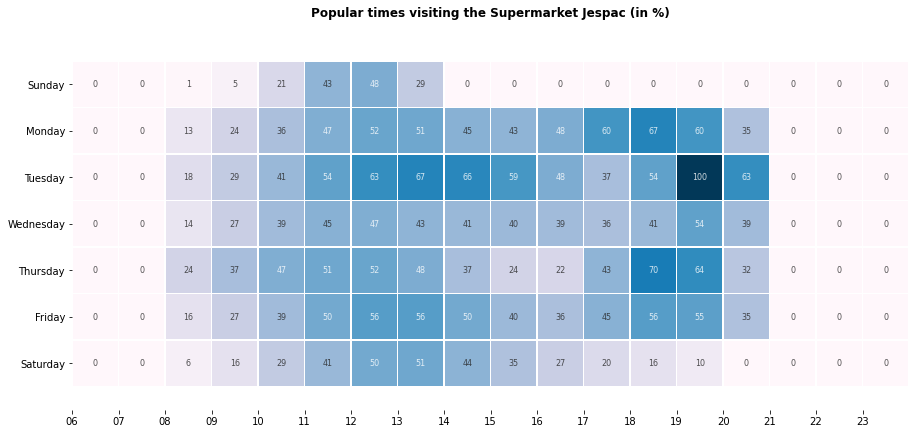

In [305]:
plt.figure(figsize=(15,7))
sns.heatmap(caprabo, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(caprabo))
plt.title('Popular times visiting the Supermarket Jespac (in %)\n', weight='semibold')

# this bit of code ensures the heatmap will not show up truncated with some versions of matplotlib
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);

In [ ]:
bcn_suMrkt = visit_planner("Supermarket / hospitals")

# we need to remove the row for Sunday before proceeding
bcn_suMrkt.drop('Sunday', axis=0, inplace=True)

for hour in list(vatican):
    vatican[hour] = re.findall('...%.{0,20} '+str(hour), str(list(HL10[HL10.full_name=="Vatican Museums"].hours)))
    vatican[hour] = [ re.findall('\d+', str(i))[0] for i in vatican[hour] ]
    vatican[hour] = vatican[hour].astype(int)

plt.figure(figsize=(15,7))
sns.heatmap(vatican, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(colosseum))
plt.title("Popular times visiting the Vatican Museums\n", weight='semibold')

# this bit of code ensures the heatmap will not show up truncated with some versions of matplotlib
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);

Hasta este punto es factible usar la herramienta de webscraping **chromedriver** para obtener informacion del sitio googlemaps.com. La pregunta sería que tipo de información resultaría necesaria de incluir en el dataset final y como se vería benefiaciado, en terminos generales si sumaria valor al dataset.  
  
Segundo el reto es poder usar los nombres de los locales comerciales en nuestro dataset y usar la herramienta para que obtenga la informacion de ese local comercial y no de otro incluso de la misma cadena en la misma ciudad. Otros puntos a resolver serían: la actual existencia de los comercios y la exacta coincidencia de los registros en nuestro dataset con las busquedas mediante la herramienta.  
  
Y por último lograr encontrar una manera de condensar la información complementaria que se pueda obtener mediante la herramienta chromedriver para no saturar el dataset final. Pensar en adjuntar solamente las features estrategicas y desestimar las innecesarias.  7
  
 Perfeccionar la tecnica de extraccion de datos.
Puntos en contra de la herramienta de webscraping: 
 * Tiene que estar controlada por un usuario para evitar errores o excepciones que finalizen subitamente la ejecución. En nuestro caso es una desventaja porque el tamaño del dataset es demasiado grande.

---

# Analísis de locales comerciales por hexángonos  <a name="t14"></a>

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon

In [3]:
map_data2 = gpd.read_file('aoi_BCN.geojson')

In [4]:
map_data = gpd.read_file('HEX_BCN.geojson')
d_set = pd.read_csv('points_inside_CLEAN.csv')

In [ ]:
import folium

m = folium.Map([41.3887901,2.1589899], zoom_start=13, tiles='cartodbpositron')
folium.GeoJson(map_data2).add_to(m)
folium.GeoJson(map_data).add_to(m)
folium.LatLngPopup().add_to(m)
def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=2,
                        weight=1).add_to(m)
d_set.apply(plotDot, axis = 1)
m

<img src="com_in_hexa.png">

In [5]:
df = pd.read_csv('df_sup.csv')

In [6]:
df['franchise'].unique()

array([0., 1.])

In [7]:
df.head()

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,polygon,franchise,in_hex,in_poly
0,83969.0,Garces Taller,78,CL ROCAFORT,9.0,12.0,tran,tall,taller mecánico,429313.0,4581410.0,2.153513,41.379259,POINT (2.153512887 41.37925891),115.0,out,0.0,1097.0,0
1,117499.0,Anton Solé,10,PZ NAVAS,9.0,12.0,tran,tall,taller mecánico,429739.0,4580810.0,2.158677,41.373892,POINT (2.158676542 41.37389224),115.0,out,0.0,1158.0,0
2,117503.0,Auto.Carburación,1,CL TEODOR BONAPLATA,9.0,12.0,tran,tall,taller mecánico,429786.0,4580886.0,2.159230,41.374581,POINT (2.159229711 41.37458085),115.0,out,0.0,1158.0,0
3,117511.0,"M.F, Flomart",30,PS MONTJUIC,9.0,12.0,tran,tall,taller mecánico,430800.0,4580634.0,2.171383,41.372399,POINT (2.171382973 41.37239903),115.0,out,0.0,1185.0,0
4,117515.0,F.Espunes,68,PS MONTJUIC,9.0,12.0,tran,tall,taller mecánico,430491.0,4580569.0,2.167696,41.371787,POINT (2.167695814 41.37178696),115.0,out,0.0,1183.0,0


In [156]:
df_82 = df.loc[df.loc[:, 'in_hex'] == 0 ]
df_82 = df_82.loc[df_82.loc[:, 'polygon'] != 'out']
df_82

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,polygon,franchise,in_hex,in_poly
77412,222238.0,CLUB ESPORTIU MEDITERRANI - REGENT MENDIETA,14-20,Regent Mendieta,8.0,54.0,serv,insdepo,instalación deportiva,426647.6584,4581055.343,2.121684,41.375826,POINT (2.121684146 41.37582598),64.0,aoi_65,0.0,0.0,1


In [137]:
df_82.polygon.unique()

array(['out', 'aoi_65'], dtype=object)

In [8]:
df.shape

(80062, 19)

In [9]:
len(df['in_hex'].unique())

884

In [10]:
df.columns

Index(['id', 'title', 'number', 'street', 'id_sec', 'id_subsec', 'cod_sec',
       'cod_sub', 'sector', 'x', 'y', 'lon', 'lat', 'geometry', 'polygon_id',
       'polygon', 'franchise', 'in_hex', 'in_poly'],
      dtype='object')

In [258]:
df_test = df.loc[df.loc[:, 'in_poly'] != 0]
df_test = df_test.loc[df_test.loc[:, 'in_hex'] != 0]
df_test.shape

(23345, 19)

In [259]:
df_test['ones'] = 1

In [219]:
df_poly = df[['in_hex','polygon','polygon_id']]
df_poly = df_poly.loc[df_poly.loc[:, 'polygon'] != 'out']
df_poly = df_poly.loc[df_poly.loc[:, 'in_hex'] != 0]
df_poly.shape

(23345, 3)

In [220]:
len(df_poly.in_hex.unique())

278

In [221]:
df_poly = df_poly.drop_duplicates()

In [222]:
df_poly.shape

(348, 3)

In [223]:
len(df_poly.polygon.unique())

82

In [224]:
is_82 = df_poly.loc[:, 'polygon_id'] == 64
df_82 = df_poly.loc[is_82]

In [225]:
df_82

,in_hex,polygon,polygon_id
1746,1148.0,aoi_65,64.0
3182,1147.0,aoi_65,64.0
3959,1119.0,aoi_65,64.0
6984,1146.0,aoi_65,64.0
7380,1118.0,aoi_65,64.0
7384,1089.0,aoi_65,64.0
11053,1149.0,aoi_65,64.0
20192,1120.0,aoi_65,64.0


In [226]:
df_poly.head()

,in_hex,polygon,polygon_id
13,426.0,aoi_24,23.0
16,170.0,aoi_20,19.0
34,903.0,aoi_35,34.0
49,887.0,aoi_2,1.0
57,1160.0,aoi_100,99.0


In [227]:
grouped_df = df_poly.groupby("in_hex")["polygon"].unique()

In [228]:
grouped_df.head()

in_hex
88.0     [aoi_19]
112.0    [aoi_19]
113.0    [aoi_19]
114.0    [aoi_19]
137.0    [aoi_17]
Name: polygon, dtype: object

In [229]:
grouped_df = pd.DataFrame(grouped_df)

In [230]:
grouped_df['in_hex'] = grouped_df.index
grouped_df.reset_index(drop=True, inplace=True)

In [231]:
grouped_df.dtypes

polygon     object
in_hex     float64
dtype: object

In [232]:
grouped_df.shape

(278, 2)

In [233]:
grouped_df.tail()

,polygon,in_hex
273,[aoi_101],1161.0
274,[aoi_89],1167.0
275,[aoi_89],1168.0
276,[aoi_100],1182.0
277,"[aoi_101, aoi_100]",1183.0


In [235]:
df_test

,id,title,number,street,id_sec,id_subsec,cod_sec,cod_sub,sector,x,y,lon,lat,geometry,polygon_id,polygon,franchise,in_hex,in_poly,ones
13,117733.0,Gamez Taller De Reparació,60,CL PINAR DEL RIO,9.0,12.0,tran,tall,taller mecánico,431573.0000,4586221.000,2.179994,41.422786,POINT (2.179993778 41.42278554),23.0,aoi_24,0.0,426.0,1,1
16,117959.0,Talleres Francés,5,CL LANZAROTE,9.0,12.0,tran,tall,taller mecánico,432400.0000,4587933.000,2.189698,41.438275,POINT (2.189698083 41.43827499),19.0,aoi_20,0.0,170.0,1,1
34,165000.0,Taller Mecànic,88,CL PAMPLONA,9.0,12.0,tran,tall,taller mecánico,432507.0000,4583351.000,2.191490,41.397015,POINT (2.191490294 41.39701537),34.0,aoi_35,0.0,903.0,1,1
49,123673.0,Motos Calvet,67,CL AMIGO,9.0,12.0,tran,tall,taller mecánico,428413.0000,4583354.000,2.142521,41.396688,POINT (2.142520958 41.39668817),1.0,aoi_2,0.0,887.0,1,1
50,123732.0,Motos Calvet,31,CL CALVET,9.0,12.0,tran,tall,taller mecánico,428448.0000,4583160.000,2.142963,41.394944,POINT (2.14296253 41.394944),1.0,aoi_2,0.0,887.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80030,226720.0,Fiscalia de la Comunitat Autónoma de Catalunya,158,de Pau Claris,5.0,80.0,other,juz,juzgado,430159.0980,4582983.553,2.163449,41.393505,POINT (2.163448961 41.39350531),9.0,aoi_10,0.0,931.0,1,1
80051,912866.0,Ambilamp,12,PZ CATALUNYA,5.0,562.0,other,eco,"recogida residuos, incineración, reciclaje, pr...",430767.0500,4582371.397,2.170790,41.388044,POINT (2.1707904 41.3880444),95.0,aoi_96,0.0,1003.0,1,1
80053,938198.0,Ambilamp,12,PZ CATALUNYA,5.0,562.0,other,eco,"recogida residuos, incineración, reciclaje, pr...",430767.0500,4582371.397,2.170790,41.388044,POINT (2.1707904 41.3880444),95.0,aoi_96,0.0,1003.0,1,1
80058,859094.0,Taxi Auto 1,594,CL CORSEGA,5.0,140.0,other,taxi,taxi,431228.0343,4584652.459,2.176044,41.408629,POINT (2.176044351 41.40862877),28.0,aoi_29,0.0,683.0,1,1


In [260]:
pivost = pd.pivot_table(df_test, values='ones', 
                    index=['in_hex'], 
                    columns='cod_sec',
                    aggfunc='sum')

In [261]:
pivost.shape

(278, 10)

In [262]:
pivost

cod_sec,altr,cult,host,llar,localb,other,pers,quot,serv,tran
in_hex,,,,,,,,,,
88.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
112.0,5.0,3.0,12.0,8.0,31.0,2.0,22.0,24.0,34.0,5.0
113.0,4.0,2.0,18.0,12.0,70.0,7.0,20.0,34.0,52.0,13.0
114.0,1.0,NaN,11.0,2.0,23.0,2.0,6.0,9.0,16.0,NaN
137.0,2.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1161.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,2.0,NaN
1167.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN
1168.0,1.0,NaN,13.0,NaN,2.0,4.0,5.0,2.0,8.0,2.0


In [263]:
flat_pivot = pd.DataFrame(pivost.to_records())

In [264]:
flat_pivot.head()

,in_hex,altr,cult,host,llar,localb,other,pers,quot,serv,tran
0,88.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,112.0,5.0,3.0,12.0,8.0,31.0,2.0,22.0,24.0,34.0,5.0
2,113.0,4.0,2.0,18.0,12.0,70.0,7.0,20.0,34.0,52.0,13.0
3,114.0,1.0,NaN,11.0,2.0,23.0,2.0,6.0,9.0,16.0,NaN
4,137.0,2.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN


In [265]:
pivost = pd.merge(flat_pivot, df_poly, on = 'in_hex', how='outer')
pivost

,in_hex,altr,cult,host,llar,localb,other,pers,quot,serv,tran,polygon,polygon_id
0,88.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,aoi_19,18.0
1,112.0,5.0,3.0,12.0,8.0,31.0,2.0,22.0,24.0,34.0,5.0,aoi_19,18.0
2,113.0,4.0,2.0,18.0,12.0,70.0,7.0,20.0,34.0,52.0,13.0,aoi_19,18.0
3,114.0,1.0,NaN,11.0,2.0,23.0,2.0,6.0,9.0,16.0,NaN,aoi_19,18.0
4,137.0,2.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,aoi_17,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1167.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,aoi_89,88.0
344,1168.0,1.0,NaN,13.0,NaN,2.0,4.0,5.0,2.0,8.0,2.0,aoi_89,88.0
345,1182.0,1.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,3.0,NaN,aoi_100,99.0
346,1183.0,4.0,1.0,20.0,5.0,26.0,8.0,2.0,9.0,17.0,1.0,aoi_101,100.0


In [266]:
pivost.loc[pivost.loc[:, 'polygon'] == 'aoi_65' ]

,in_hex,altr,cult,host,llar,localb,other,pers,quot,serv,tran,polygon,polygon_id
291,1089.0,2.0,NaN,7.0,3.0,4.0,1.0,5.0,1.0,3.0,1.0,aoi_65,64.0
311,1118.0,14.0,4.0,16.0,6.0,28.0,6.0,5.0,15.0,36.0,3.0,aoi_65,64.0
312,1119.0,5.0,4.0,19.0,12.0,23.0,7.0,1.0,10.0,30.0,5.0,aoi_65,64.0
313,1120.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,aoi_65,64.0
326,1146.0,4.0,2.0,3.0,6.0,7.0,1.0,6.0,3.0,19.0,1.0,aoi_65,64.0
327,1147.0,5.0,8.0,11.0,16.0,5.0,3.0,17.0,9.0,18.0,NaN,aoi_65,64.0
328,1148.0,5.0,NaN,9.0,11.0,11.0,3.0,14.0,11.0,30.0,2.0,aoi_65,64.0
330,1149.0,2.0,NaN,3.0,5.0,1.0,NaN,7.0,13.0,13.0,1.0,aoi_65,64.0


In [267]:
pivost.columns

Index(['in_hex', 'altr', 'cult', 'host', 'llar', 'localb', 'other', 'pers',
       'quot', 'serv', 'tran', 'polygon', 'polygon_id'],
      dtype='object')

In [268]:
print(pivost.polygon.unique)

<bound method Series.unique of 0       aoi_19
1       aoi_19
2       aoi_19
3       aoi_19
4       aoi_17
        ...   
343     aoi_89
344     aoi_89
345    aoi_100
346    aoi_101
347    aoi_100
Name: polygon, Length: 348, dtype: object>


In [269]:
pivost.to_csv('pivot_polygon_in_hex.csv', index=False)

***Continuar haciento el analisis de la distribucion de porcentajes y demas....***

In [36]:
map_data.head()

,FID,geometry
0,0,"MULTIPOLYGON (((2.18026 41.46764, 2.18026 41.4..."
1,1,"MULTIPOLYGON (((2.18335 41.46821, 2.18335 41.4..."
2,2,"MULTIPOLYGON (((2.18643 41.46774, 2.18643 41.4..."
3,3,"MULTIPOLYGON (((2.18712 41.46701, 2.18643 41.4..."
4,4,"MULTIPOLYGON (((2.17792 41.46428, 2.17718 41.4..."


In [37]:
map_data2.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry
0,aoi_1,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.13049 41.38221 0.00000, 2.13101 ..."
1,aoi_2,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14463 41.39321 0.00000, 2.14495 ..."
2,aoi_3,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14592 41.39374 0.00000, 2.14613 ..."
3,aoi_4,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14860 41.39433 0.00000, 2.14884 ..."
4,aoi_5,None,None,None,None,None,-1,0,-1,None,None,"POLYGON Z ((2.14845 41.39443 0.00000, 2.14873 ..."


In [191]:
perc = []
for i, g1 in enumerate(map_data.geometry):
    for j, g8 in enumerate(map_data2.geometry):
        if g1.intersects(g8):
            #print (i, j, (g1.intersection(g8).area/g1.area)*100)
            perc.append((i, j, (g1.intersection(g8).area/g1.area)*100))

In [192]:
perc = pd.DataFrame(perc, columns = ['in_hex' , 'polygon_id', 'percentage'])
perc

,in_hex,polygon_id,percentage
0,88,18,1.812043
1,112,18,34.733570
2,113,18,82.455762
3,114,18,29.614110
4,137,16,3.472311
...,...,...,...
391,1167,88,25.617421
392,1168,88,28.756072
393,1182,99,1.572838
394,1183,99,13.851041


In [193]:
len(perc.polygon_id.unique())

84

In [194]:
len(df_poly.polygon_id.unique())

82

In [195]:
l1 = set(perc.polygon_id.unique())

l2 = set(df_poly.polygon_id.unique())
    
r = l1.difference(l2)
if len(r) > 0 :
    print("hay {} elementos no coincidentes".format(len(r)))
    print(r)
else:
    print("no hay valores a reportar")

hay 2 elementos no coincidentes
{84, 87}


In [270]:
ta_pivoted = pd.read_csv('pivot_polygon_in_hex.csv')
ta_pivoted

,in_hex,altr,cult,host,llar,localb,other,pers,quot,serv,tran,polygon,polygon_id
0,88.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,aoi_19,18.0
1,112.0,5.0,3.0,12.0,8.0,31.0,2.0,22.0,24.0,34.0,5.0,aoi_19,18.0
2,113.0,4.0,2.0,18.0,12.0,70.0,7.0,20.0,34.0,52.0,13.0,aoi_19,18.0
3,114.0,1.0,NaN,11.0,2.0,23.0,2.0,6.0,9.0,16.0,NaN,aoi_19,18.0
4,137.0,2.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,aoi_17,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1167.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,aoi_89,88.0
344,1168.0,1.0,NaN,13.0,NaN,2.0,4.0,5.0,2.0,8.0,2.0,aoi_89,88.0
345,1182.0,1.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,3.0,NaN,aoi_100,99.0
346,1183.0,4.0,1.0,20.0,5.0,26.0,8.0,2.0,9.0,17.0,1.0,aoi_101,100.0


In [271]:
len(ta_pivoted.in_hex.unique())

278

In [302]:
piv_final = pd.merge(ta_pivoted, perc, on = 'polygon_id' and 'in_hex', how='outer')
piv_final

,in_hex,altr,cult,host,llar,localb,other,pers,quot,serv,tran,polygon,polygon_id_x,polygon_id_y,percentage
0,88.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,aoi_19,18.0,18,1.812043
1,112.0,5.0,3.0,12.0,8.0,31.0,2.0,22.0,24.0,34.0,5.0,aoi_19,18.0,18,34.733570
2,113.0,4.0,2.0,18.0,12.0,70.0,7.0,20.0,34.0,52.0,13.0,aoi_19,18.0,18,82.455762
3,114.0,1.0,NaN,11.0,2.0,23.0,2.0,6.0,9.0,16.0,NaN,aoi_19,18.0,18,29.614110
4,137.0,2.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,aoi_17,16.0,16,3.472311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,1090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.348283
569,1122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,0.433059
570,1123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,21.634081
571,1125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,0.030628


In [303]:
piv_final.shape

(573, 15)

In [304]:
len(piv_final.polygon_id_y.unique())

84

In [305]:
len(piv_final.polygon.unique())

83

In [332]:
piv_final.drop(piv_final[piv_final.polygon.isnull()].index, inplace = True)
piv_final

,in_hex,altr,cult,host,llar,localb,other,pers,quot,serv,tran,polygon,polygon_id_x,polygon_id_y,percentage
0,88.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,aoi_19,18.0,18,1.812043
1,112.0,5.0,3.0,12.0,8.0,31.0,2.0,22.0,24.0,34.0,5.0,aoi_19,18.0,18,34.733570
2,113.0,4.0,2.0,18.0,12.0,70.0,7.0,20.0,34.0,52.0,13.0,aoi_19,18.0,18,82.455762
3,114.0,1.0,NaN,11.0,2.0,23.0,2.0,6.0,9.0,16.0,NaN,aoi_19,18.0,18,29.614110
4,137.0,2.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,aoi_17,16.0,16,3.472311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,1182.0,1.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,3.0,NaN,aoi_100,99.0,99,1.572838
539,1183.0,4.0,1.0,20.0,5.0,26.0,8.0,2.0,9.0,17.0,1.0,aoi_101,100.0,99,13.851041
540,1183.0,4.0,1.0,20.0,5.0,26.0,8.0,2.0,9.0,17.0,1.0,aoi_101,100.0,100,0.213578
541,1183.0,4.0,1.0,20.0,5.0,26.0,8.0,2.0,9.0,17.0,1.0,aoi_100,99.0,99,13.851041


In [307]:
len(piv_final.polygon_id_x.unique())

82

In [339]:
piv_final = piv_final.drop_duplicates(['percentage'], keep='last')

In [342]:
piv_final

,in_hex,altr,cult,host,llar,localb,other,pers,quot,serv,tran,polygon,polygon_id_x,polygon_id_y,percentage
0,88.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,aoi_19,18.0,18,1.812043
1,112.0,5.0,3.0,12.0,8.0,31.0,2.0,22.0,24.0,34.0,5.0,aoi_19,18.0,18,34.733570
2,113.0,4.0,2.0,18.0,12.0,70.0,7.0,20.0,34.0,52.0,13.0,aoi_19,18.0,18,82.455762
3,114.0,1.0,NaN,11.0,2.0,23.0,2.0,6.0,9.0,16.0,NaN,aoi_19,18.0,18,29.614110
4,137.0,2.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,aoi_17,16.0,16,3.472311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,1167.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,aoi_89,88.0,88,25.617421
537,1168.0,1.0,NaN,13.0,NaN,2.0,4.0,5.0,2.0,8.0,2.0,aoi_89,88.0,88,28.756072
538,1182.0,1.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,3.0,NaN,aoi_100,99.0,99,1.572838
541,1183.0,4.0,1.0,20.0,5.0,26.0,8.0,2.0,9.0,17.0,1.0,aoi_100,99.0,99,13.851041


In [341]:
piv_final.to_csv('pivotable_final2.csv', index=False)

In [338]:
l1 = set(piv_final.index)

l2 = set(piv_final2.index)
    
r = l1.difference(l2)
if len(r) > 0 :
    print("hay {} elementos no coincidentes".format(len(r)))
    print(r)
else:
    print("no hay valores a reportar")

hay 330 elementos no coincidentes
{0, 3, 4, 11, 15, 16, 17, 18, 19, 20, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 45, 46, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 65, 66, 67, 68, 69, 70, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 112, 113, 114, 119, 120, 123, 124, 128, 129, 130, 131, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 149, 150, 159, 166, 167, 168, 169, 170, 173, 174, 175, 189, 190, 191, 192, 194, 195, 196, 197, 200, 201, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217, 226, 227, 228, 229, 231, 232, 234, 235, 237, 238, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 281, 282, 283, 284, 285, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 317, 318, 319, 323, 3

---

# Análisis Cualitativo  <a name="t15"></a>

In [246]:
df = pd.read_csv('df_sup.csv')

## Brief description of columns:  
'id': Individual identifier of each register.  
'title': Name of local commercial.  
'id_sec': Individual idenfier of principal sector. (10)  
'id_subsec': Individual identifier of subsector.  (\~130)  
'cod_sec': Principal sector code. (10)  
'cod_sub': Sub sector code. (\~130)  
'sector': Sub sector description.  
'lon' and 'lat': longitude and latittude information  
'geometry': Location format information.  
'polygon': Polygon´s name.  
'franchise': If match with retail chains list.(1 -> true, 0 -> false).  
'in_poly': Categorical feature, 0 out and 1 inside of the polygon.

In [264]:
import datashader as ds, pandas as pd
import datashader.transfer_functions as tf
from datashader.utils import export_image

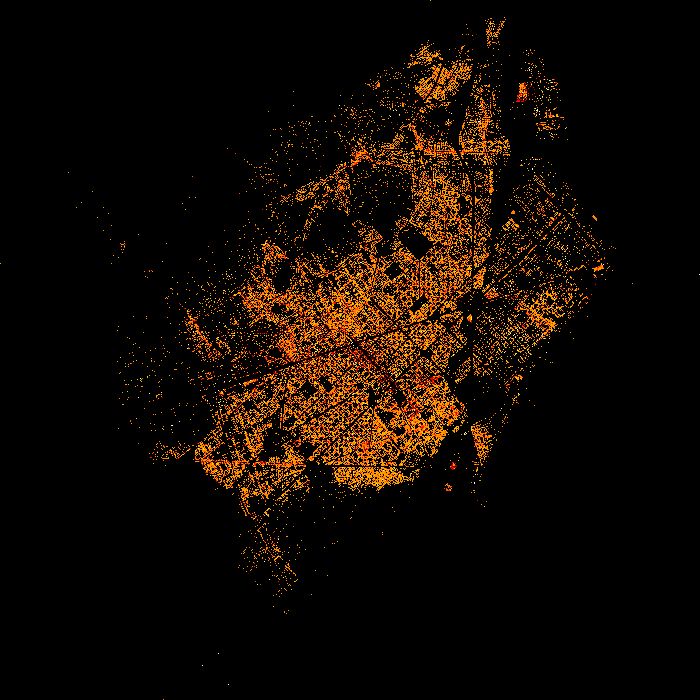

In [271]:
from datashader.colors import colormap_select, Greys9, Hot, inferno
# df_Yellow df_Green
cvs = ds.Canvas(plot_width=700, plot_height=700)
agg = cvs.points(df, 'x', 'y', ds.mean('id_subsec'))
img = tf.shade(agg, cmap=Hot, how='log')
#img = tf.shade(agg, cmap=['blueviolet', 'azure'], how='log')
figname = 'datashader_Ye_01_02'
export_image(img, figname, background="black")

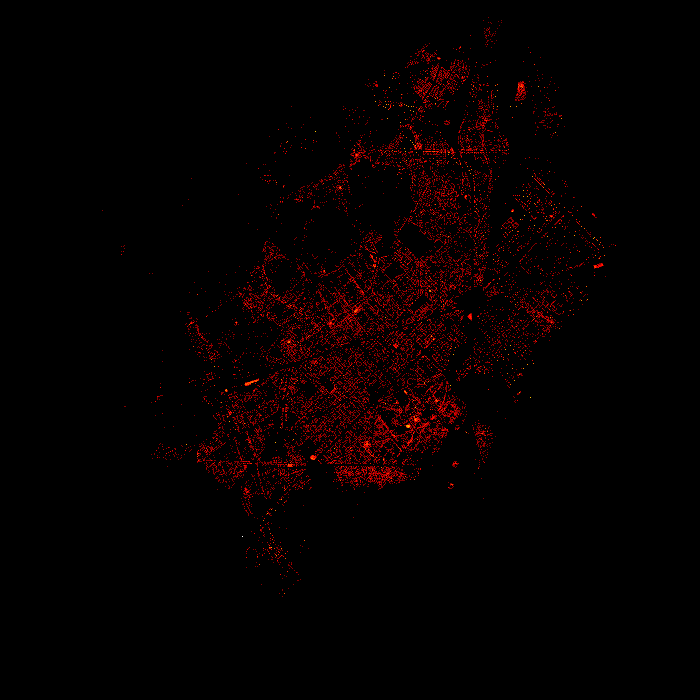

In [267]:
from datashader.colors import colormap_select, Greys9, Hot, inferno

cvs = ds.Canvas(plot_width=700, plot_height=700)
agg = cvs.points(df, 'lon', 'lat')#, ds.mean('id_subsec'))
img = tf.shade(agg, cmap=Hot, how='log')
#img = tf.shade(agg, cmap=['blueviolet', 'azure'], how='log')
figname = 'datashader_Ye_01_02'
export_image(img, figname, background="black")

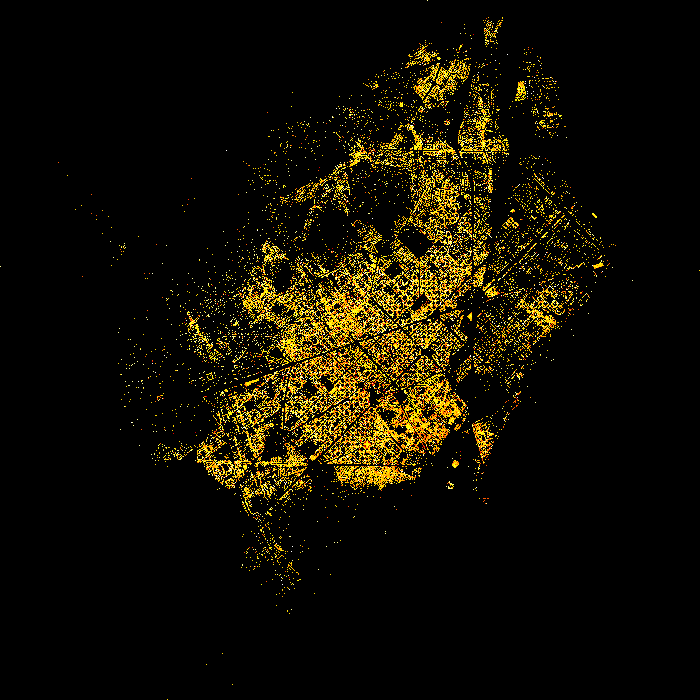

In [266]:
from datashader.colors import colormap_select, Greys9, Hot, inferno

cvs = ds.Canvas(plot_width=700, plot_height=700)
agg = cvs.points(df, 'lon', 'lat', ds.mean('id_sec'))
img = tf.shade(agg, cmap=Hot, how='log')
#img = tf.shade(agg, cmap=['blueviolet', 'azure'], how='log')
figname = 'datashader_Ye_01_03'
export_image(img, figname, background="black")

In [263]:
df.describe().round(2)

,id,id_sec,id_subsec,x,y,lon,lat,polygon_id,franchise,in_hex,in_poly
count,80062.00,80062.00,80062.00,80062.00,80062.00,80062.00,80062.00,80062.00,80062.00,80062.00,80062.00
mean,405947.71,5.10,50.83,430393.77,4583820.02,2.17,41.40,93.05,0.03,782.42,0.29
std,286367.57,2.56,69.65,1780.24,2243.52,0.02,0.02,38.42,0.17,316.39,0.45
min,13957.00,0.00,2.00,422834.48,4576385.51,2.08,41.33,0.00,0.00,0.00,0.00
25%,162407.25,3.00,15.00,429073.00,4581977.00,2.15,41.38,95.00,0.00,580.00,0.00
50%,363134.50,5.00,40.00,430507.00,4583643.00,2.17,41.40,115.00,0.00,851.00,0.00
75%,731553.75,8.00,47.00,431605.00,4585278.74,2.18,41.41,115.00,0.00,1040.00,1.00
max,940960.00,9.00,571.00,436609.18,4589993.61,2.24,41.46,115.00,1.00,1431.00,1.00


In [247]:
df['franchise'].unique()

array([0., 1.])

In [248]:
col = df.columns.tolist()
for column in col:
  print("{}: {}".format(column, df[column].isnull().sum()))

id: 0
title: 0
number: 0
street: 0
id_sec: 0
id_subsec: 0
cod_sec: 0
cod_sub: 0
sector: 0
x: 0
y: 0
lon: 0
lat: 0
geometry: 0
polygon_id: 0
polygon: 0
franchise: 0
in_hex: 0
in_poly: 0



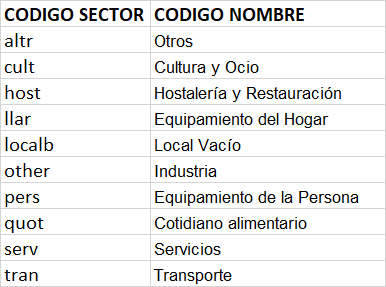

## Tablas de frecuencia

In [249]:
# tabla de frecuencia de categoria sectores
pd.value_counts(df['cod_sec'])

serv      19234
localb    13824
host      12043
pers       8259
quot       8192
other      5988
llar       3572
altr       3528
tran       2793
cult       2629
Name: cod_sec, dtype: int64

In [250]:
# tabla de frecuencia de categoria sectores
100 * df['cod_sec'].value_counts() / len(df['cod_sec'])

serv      24.023881
localb    17.266618
host      15.042092
pers      10.315755
quot      10.232070
other      7.479204
llar       4.461542
altr       4.406585
tran       3.488546
cult       3.283705
Name: cod_sec, dtype: float64

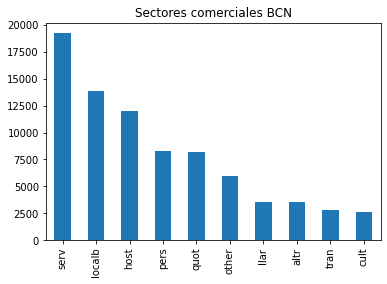

In [251]:
# Gráfico de barras de pasajeros del Titanic
plot = df['cod_sec'].value_counts().plot(kind='bar',
                                            title='Sectores comerciales BCN')

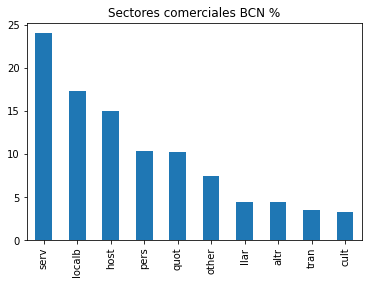

In [252]:
# gráfico de barras de frecuencias relativas.
plot = (100 * df['cod_sec'].value_counts() / len(df['cod_sec'])).plot(
kind='bar', title='Sectores comerciales BCN %')

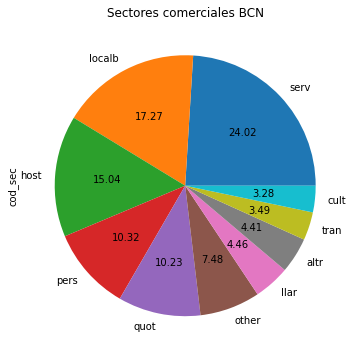

In [253]:
# Gráfico de tarta de pasajeros del Titanic
plot = df['cod_sec'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Sectores comerciales BCN')

## Tablas de contingencia

In [254]:
pd.crosstab(index=df['franchise'],
            columns=df['cod_sec'], margins=True)

cod_sec,altr,cult,host,llar,localb,other,pers,quot,serv,tran,All
franchise,,,,,,,,,,,
0.0,3519,2585,11789,3519,13823,5981,7391,7489,18838,2791,77725
1.0,9,44,254,53,1,7,868,703,396,2,2337
All,3528,2629,12043,3572,13824,5988,8259,8192,19234,2793,80062


In [255]:
# tabla de contingencia en porcentajes relativos total
pd.crosstab(index=df['franchise'], columns=df['cod_sec'],
            margins=True).apply(lambda r: r/len(df) *100,
                                axis=1)

cod_sec,altr,cult,host,llar,localb,other,pers,quot,serv,tran,All
franchise,,,,,,,,,,,
0.0,4.395344,3.228748,14.724838,4.395344,17.265369,7.470460,9.231596,9.354001,23.529265,3.486048,97.081012
1.0,0.011241,0.054957,0.317254,0.066199,0.001249,0.008743,1.084160,0.878069,0.494617,0.002498,2.918988
All,4.406585,3.283705,15.042092,4.461542,17.266618,7.479204,10.315755,10.232070,24.023881,3.488546,100.000000


In [256]:
# tabla de contingencia en porcentajes relativos segun franquicia
pd.crosstab(index=df['franchise'], columns=df['cod_sec']
           ).apply(lambda r: r/r.sum() *100,
                                axis=1)

cod_sec,altr,cult,host,llar,localb,other,pers,quot,serv,tran
franchise,,,,,,,,,,
0.0,4.527501,3.325828,15.167578,4.527501,17.784497,7.695079,9.509167,9.635252,24.236732,3.590865
1.0,0.385109,1.882756,10.868635,2.267865,0.042790,0.299529,37.141635,30.081301,16.944801,0.085580


In [257]:
# tabla de contingencia en porcentajes relativos segun sector
pd.crosstab(index=df['franchise'], columns=df['cod_sec']
           ).apply(lambda r: r/r.sum() *100,
                                axis=0)

cod_sec,altr,cult,host,llar,localb,other,pers,quot,serv,tran
franchise,,,,,,,,,,
0.0,99.744898,98.32636,97.890891,98.516237,99.992766,99.8831,89.490253,91.418457,97.941146,99.928392
1.0,0.255102,1.67364,2.109109,1.483763,0.007234,0.1169,10.509747,8.581543,2.058854,0.071608


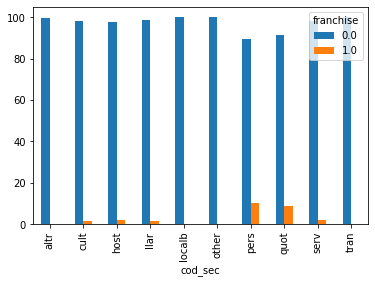

In [258]:
# Gráfico de barras de franquicia segun sector
plot = pd.crosstab(index=df['cod_sec'],
            columns=df['franchise']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar')

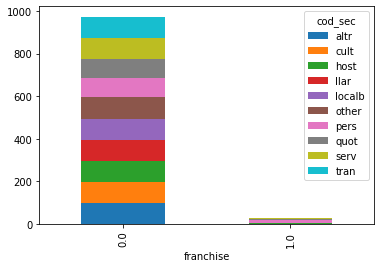

In [259]:
# Gráfico de barras de sobreviviviente segun clase
plot = pd.crosstab(index=df['franchise'],
            columns=df['cod_sec']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True)

In [260]:
df.shape

(80062, 19)

In [261]:
pd.crosstab(index=df['franchise'],
            columns=df['in_poly'], margins=True)

in_poly,0,1,All
franchise,,,
0.0,55508,22217,77725
1.0,1208,1129,2337
All,56716,23346,80062


# Análisis Cuantitivativo  <a name="t16"></a>

# Xtra Ki  <a name="t17"></a>

In [2]:
from selenium import webdriver

In [74]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementNotInteractableException, ElementClickInterceptedException

In [77]:
from tqdm import tqdm_notebook as tqdmn

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import folium

In [80]:
import time, re

In [192]:
df = pd.read_csv('df_sup.csv', usecols=['title','street','number'])

In [193]:
df.loc[df['title'] == 'Anton Solé', 'title'] = 'Taller Anton Solé'
df['title'] = df['title'].str.replace('F.Espunes','Talleres Espuña')
df.loc[df['title'] == 'Herpa', 'title'] = 'Erpa'
df.loc[df['title'] == 'Emauto S.C', 'number'] = '40'
df.loc[df['title'] == 'Emauto S.C', 'title'] = 'Em Auto S.C.'
df.loc[df['title'] == 'Findal', 'number'] = '128' 
df.loc[df['title'] == 'Findal', 'street'] = 'CL PUIG CERDÁ'
df.loc[df['title'] == 'Tallers Ulibarri', 'title'] = 'Talleres Chicote'

In [194]:
df['street'] = df['street'].str.replace('CL','Carrer')
df['street'] = df['street'].str.replace('PZ','Plaça')
df['street'] = df['street'].str.replace('PS','Passeig')

df['serch_o'] = df['title']+' '+df['street']+', '+df['number']

In [195]:
df

,title,number,street,serch_o
0,Garces Taller,78,Carrer ROCAFORT,"Garces Taller Carrer ROCAFORT, 78"
1,Taller Anton Solé,10,Plaça NAVAS,"Taller Anton Solé Plaça NAVAS, 10"
2,Auto.Carburación,1,Carrer TEODOR BONAPLATA,"Auto.Carburación Carrer TEODOR BONAPLATA, 1"
3,"M.F, Flomart",30,Passeig MONTJUIC,"M.F, Flomart Passeig MONTJUIC, 30"
4,Talleres Espuña,68,Passeig MONTJUIC,"Talleres Espuña Passeig MONTJUIC, 68"
...,...,...,...,...
80057,Taxi a punto,54,Carrer ALMOGAVERS,"Taxi a punto Carrer ALMOGAVERS, 54"
80058,Taxi Auto 1,594,Carrer CORSEGA,"Taxi Auto 1 Carrer CORSEGA, 594"
80059,EQ Esteve,17-19,Carrer CARACAS,"EQ Esteve Carrer CARACAS, 17-19"
80060,Apsys,4-8,Carrer VENTURA PLAJA,"Apsys Carrer VENTURA PLAJA, 4-8"


# Pruebas  <a name="t18"></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
import folium
import time, re
from tqdm import tqdm_notebook as tqdmn

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementNotInteractableException, ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [82]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

In [196]:
options = webdriver.ChromeOptions()

options.add_argument('headless')

browser = webdriver.Chrome(options=options)

starting_business = df['serch_o']

full_name = []
rating = []
total_ratings = []
business_cat = []
address = []
phone = []
website = []
lat = []
long = []

for business in tqdmn(starting_business, leave=False, desc='2. Extrayendo los datos') :
    
    # URL making :
    url = 'https://www.google.com/maps/search/' + business
    browser.get(url)
    # Waiting for the name of the business to load and be visible. If it fails, skip to next business in competition list :
    try :
        WebDriverWait(browser,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))
    except (NoSuchElementException, TimeoutException) as e :
        continue
    
        # Extracting the data and putting it into the empty lists we defined earlier :
    try:
        full_name.append(browser.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]').text)
    except NoSuchElementException :
        full_name.append(np.nan)

    try:
        rating.append(browser.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[1]/span/span').text)
    except NoSuchElementException :
        rating.append(np.nan)

    try:
        total_ratings.append(browser.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[1]/span[2]/span[1]/button').text)
    except NoSuchElementException:
        total_ratings.append(np.nan)

    try:
        business_cat.append(browser.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').text)
    except NoSuchElementException:
        business_cat.append(np.nan)
    
    try:#falla
        address.append(browser.find_element_by_css_selector('div[data-tooltip="Copiar la dirección"]').text)
    except NoSuchElementException :
        address.append(np.nan)
    
    try:
        phone.append(browser.find_element_by_css_selector('div[data-tooltip="Copiar el número de teléfono"]').text)
    except NoSuchElementException :
        phone.append(np.nan)

    try:
        website.append(browser.find_element_by_css_selector('div[data-tooltip="Abrir el sitio web"]').text)
    except NoSuchElementException :
        website.append(np.nan)
    
    try:
        coordinates = browser.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content')
        coordinates = coordinates.split('?center=')[1].split('&zoom=')[0].split('%2C')
        lat.append(coordinates[0])
        long.append(coordinates[1])
    except NoSuchElementException:
        lat.append(np.nan)
        long.append(np.nan)
# Closing the Chrome window
browser.close()


KeyboardInterrupt: 

In [197]:
PS = pd.DataFrame(data={'full_name':full_name, 'rating':rating, 'total_ratings':total_ratings, 'business_category':business_cat, 'address':address, 'phone':phone, 'website':website, 'latitude':lat, 'longitude':long})

In [198]:
PS

,full_name,rating,total_ratings,business_category,address,phone,website,latitude,longitude
0,Tallers Garcés,4.1,(10),Taller de automóviles,"Carrer de Rocafort, 78, 08015 Barcelona",934 23 10 93,NaN,41.3793706,2.1537536
1,Taller Antón Solé,NaN,NaN,,"Plaça de las Navas, 10, 08004 Barcelona",934 23 45 63,NaN,41.3740345,2.1587754
2,Auto Carburacion e Inyeccion,5.0,(2),Taller de reparación de vehículos todoterreno,"C/ d'Entença, 20, 08015 Barcelona",933 25 46 94,NaN,41.3760141,2.1556153
3,MF Flomart,4.9,(35),Tienda de repuestos para automóviles,"Passeig de Montjuïc, 30, 08004 Barcelona",934 41 13 48,NaN,41.372421,2.17151
4,Talleres Espuña,4.6,(10),Taller de reparación de automóviles,"Passeig de Montjuïc, 68, 08004 Barcelona",934 41 48 10,NaN,41.3717558,2.167712
...,...,...,...,...,...,...,...,...,...
2003,Sant Pacià,4.3,(164),Iglesia católica,08030 Barcelona,933 46 65 54,conferenciaepiscopal.es,41.431429,2.1871609
2004,Habitatges Amb Serveis Per A Gent Gran Reina A...,5.0,(2),Oficina de gobierno local,"Carrer de la Lleialtat, 7, 08001 Barcelona",931 15 85 43,NaN,41.3773257,2.1673687
2005,Cera 23,4.6,"(1,492)",Restaurante de cocina española,"Carrer de la Cera, 23, 08001 Barcelona",934 42 08 08,cera23.com,41.3788811,2.1663227
2006,Cera 23,4.6,"(1,492)",Restaurante de cocina española,"Carrer de la Cera, 23, 08001 Barcelona",934 42 08 08,cera23.com,41.3788811,2.1663227


In [199]:
PS.to_csv('ratings_gmaps.csv', index=False)

In [ ]:
# Make sure to supply the path to where you put the chromedriver.exe file. Use \\ instead of \ :
driver = webdriver.Chrome("C:\\webdrivers\chromedriver.exe")

# This is the list where we'll capture the competitors' names and addresses
competition = []

# The name and location of the initial print shop that will go into the search URL
starting_business = 'Sfera'
city = 'Barcelona'
url = 'https://www.google.com/maps/search/' + starting_business + ' ' + city

# Opening the search URL. You'll notice a chrome window opening :
driver.get(url)

# Waiting for the name of the business to load and be visible :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))

# Clicking on the business category :
driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').click()

# Waiting for the results to appear :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))
        
# We repeat the code below 5 times (if we arrive at the end of the navgation list the loop breaks on its own) :
for i in tqdmn(range(5), leave=False, desc='1. Rounding the competition' ) :
    
    # Waiting for the results to appear :
    WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))

    # Capturing the names and addresses of the competitors and adding them to our list 'competition' :
    result_names = [i.text for i in driver.find_elements_by_css_selector('h3[class=section-result-title]')]
    result_addresses = [i.text for i in driver.find_elements_by_css_selector('span[class=section-result-location]')] 
    
    for name, address in zip(result_names, result_addresses) :
        competition.append(name + ' ' + address)
        
    # Waiting for the 'Next' button to be visible and then click it (if it's not clickable, we break the for loop) :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='n7lv7yjyC35__section-pagination-button-next']"))).click()
    except ElementClickInterceptedException :
        break
        
    # Waiting 5 seconds before looping (otherwise we get the error ElementClickInterceptedException). If you get the
    #exception, make it wait for a little longer than 5 seconds :
    time.sleep(5)

# We want to remove any '/' character in the names and addresses in the competition list (because they'll break URLs) :
competition = [i.replace('/', ' ') for i in competition]

# These are the empty lists we will populate with the extracted data in the 2nd phase :
full_name = []
rating = []
total_ratings = []
business_cat = []
address = []
phone = []
website = []
lat = []
long = []
    
# Here's the big loop iterating over the competiton list :
for business in tqdmn(competition, leave=False, desc='2. Extracting the data') :
    
    # URL making :
    url = 'https://www.google.com/maps/search/' + business
    driver.get(url)

    # Waiting for the name of the business to load and be visible. If it fails, skip to next business in competition list :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))
    except (NoSuchElementException, TimeoutException) as e :
        continue
        
    # Extracting the data and putting it into the empty lists we defined earlier :
    try:
        full_name.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]').text)
    except NoSuchElementException :
        full_name.append(np.nan)

    try:
        rating.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[1]/span/span').text)
    except NoSuchElementException :
        rating.append(np.nan)

    try:
        total_ratings.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[1]/span[2]/span[1]/button').text)
    except NoSuchElementException:
        total_ratings.append(np.nan)

    try:
        business_cat.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').text)
    except NoSuchElementException:
        business_cat.append(np.nan)
    
    try:#falla
        address.append(driver.find_element_by_css_selector('div[data-tooltip="Copiar la dirección"]').text)
    except NoSuchElementException :
        address.append(np.nan)
    
    try:
        phone.append(driver.find_element_by_css_selector('div[data-tooltip="Copiar el número de teléfono"]').text)
    except NoSuchElementException :
        phone.append(np.nan)

    try:
        website.append(driver.find_element_by_css_selector('div[data-tooltip="Abrir el sitio web"]').text)
    except NoSuchElementException :
        website.append(np.nan)
    
    try:
        coordinates = driver.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content')
        coordinates = coordinates.split('?center=')[1].split('&zoom=')[0].split('%2C')
        lat.append(coordinates[0])
        long.append(coordinates[1])
    except NoSuchElementException:
        lat.append(np.nan)
        long.append(np.nan)

# Closing the Chrome window
driver.close()

In [118]:
PS = pd.DataFrame(data={'full_name':full_name, 'rating':rating, 'total_ratings':total_ratings, 'business_category':business_cat, 'address':address, 'phone':phone, 'website':website, 'latitude':lat, 'longitude':long})

In [119]:
PS

,full_name,rating,total_ratings,business_category,address,phone,website,latitude,longitude
0,Tallers Garcés,4.1,(10),Taller de automóviles,"Carrer de Rocafort, 78, 08015 Barcelona",934 23 10 93,NaN,41.3793706,2.1537536
1,Taller Antón Solé,NaN,NaN,,"Plaça de las Navas, 10, 08004 Barcelona",934 23 45 63,NaN,41.3740345,2.1587754
2,Auto Carburacion e Inyeccion,5.0,(2),Taller de reparación de vehículos todoterreno,"C/ d'Entença, 20, 08015 Barcelona",933 25 46 94,NaN,41.3760141,2.1556153
3,MF Flomart,4.9,(35),Tienda de repuestos para automóviles,"Passeig de Montjuïc, 30, 08004 Barcelona",934 41 13 48,NaN,41.372421,2.17151


In [ ]:
from selenium import webdriver

options = webdriver.ChromeOptions()

options.add_argument('headless')

browser = webdriver.Chrome(options=options)

info_com = []

starting_business = 'Garces Taller 78 CL ROCAFORT'
city = 'Barcelona'
url = 'https://www.google.com/maps/search/' + starting_business + ' ' + city
browser.get(url)

browser.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div/div/div/div/div/div/div/div/h3').click()

# review titles / username / Person who reviews
#rating = []
total_ratings = []
phone = []

rating = browser.find_element_by_xpath('//*[@id="pane"]/div/div/div/div/div/div/div/div/div/span/span').text
total_ratings = browser.find_element_by_xpath('//*[@id="pane"]/div/div/div/div/div/div/div/div/div/span/span/span/span/span').text

print(rating)
#total_ratings = browser.find_elements_by_class_name("widget-pane-content-link")
print(total_ratings)
#total_ratings = browser.find_elements_by_class_name("widget-pane-link")
#print(phone)

In [31]:
from selenium import webdriver

options = webdriver.ChromeOptions()

options.add_argument('headless')

browser = webdriver.Chrome(options=options)

url = "https://www.google.com/maps/place/Talleres+Garc%C3%A9s+2002+S+L/@41.4024448,2.1613792,17z/data=!4m7!3m6!1s0x12a4a2bf9522aa01:0x976463a8563882ae!8m2!3d41.4024408!4d2.1635679!9m1!1b1"

browser.get(url)

# review titles / username / Person who reviews

review_titles = browser.find_elements_by_class_name("section-review-title")

print([a.text for a in review_titles])

# review text / what did they think

review_text = browser.find_elements_by_class_name("section-review-review-content")

print([a.text for a in review_text])

# get the numbers of stars

review_stars = browser.find_elements_by_class_name("section-review-stars")
cnt = range(len([a.text for a in review_stars]))
list_st = []
for n in cnt:
    first_review_stars = review_stars[n]
    active_stars = first_review_stars.find_elements_by_class_name("section-review-star-active")
    list_st.append(len(active_stars))
print(list_st)
browser.close()


[]
['Mi taller de chapa y pintura. Precios.muy ajustados gran calidad en el servicio.', 'Lleve el coche por un golpe en el frontal les llame les expliqué el tipo de golpe y la necesidad que la reparación fuera lo mas rápido posible y me dijeron que en un día posiblemente, no me lo aseguraron por supuesto, el perito lo podía…', 'Tanto el trato conmigo como la reparación entera del coche ha sido inmejorable, muy recomendado.', 'Taller 100% recomendable muy atentos y rápidos te atienden súper bien y te devuelve el coche limpio por dentro y por fuera trato muy agradable 100% recomendable y te dejan un coche de sustitución la mar de bien gracias por todo un gran saludo maquinas', 'Es un taller de chapa,son profesionales y técnicos y son rápidos hay que pedir hora con tiempo.', 'Personal muy eficaz y profesionales', 'Ayer por la mañana día 10/12/18 deje el coche para chapa y pintura, (varias zonas) y hoy 11/12/18 por la tarde lo tenía listo. Rápidos, pulidos y muy buena atención al cliente. 

In [155]:
from selenium import webdriver


options = webdriver.ChromeOptions()

options.add_argument('headless')


browser = webdriver.Chrome(options=options)

url = "https://www.google.com/maps/place/talleres+garc%C3%A9s/@41.3798386,2.1569933,17z/data=!3m1!4b1!4m10!1m2!2m1!1sTalleres+Garc%C3%A9s!3m6!1s0x12a4a2623d440001:0x92bb53e5ee91114f!8m2!3d41.3798346!4d2.159182!9m1!1b1"

#url = "https://www.google.com/maps/place/Talleres+Garc%C3%A9s+2002+S+L/@41.4024448,2.1613792,17z/data=!4m7!3m6!1s0x12a4a2bf9522aa01:0x976463a8563882ae!8m2!3d41.4024408!4d2.1635679!9m1!1b1"

#url = "https://www.google.com/maps/place/Talleres+Garc%C3%A9s+2002+S+L/@41.4024448,2.1613792,17z/data=!3m1!4b1!4m5!3m4!1s0x12a4a2bf9522aa01:0x976463a8563882ae!8m2!3d41.4024408!4d2.1635679"

# url = "https://www.google.com/maps/place/Lucky+Dhaba/@30.653792,76.8165233,17z/data=!3m1!4b1!4m5!3m4!1s0x390feb3e3de1a031:0x862036ab85567f75!8m2!3d30.653792!4d76.818712"


browser.get(url)


# review titles / username / Person who reviews

review_titles = browser.find_elements_by_class_name("section-review-title")

print([a.text for a in review_titles])

# review text / what did they think

review_text = browser.find_elements_by_class_name("section-review-review-content")

print([a.text for a in review_text])

# get the number of stars

review_stars = browser.find_elements_by_class_name("section-review-stars")
cnt = range(len([a.text for a in review_stars]))
list_st = []
for n in cnt:
    first_review_stars = review_stars[n]
    active_stars = first_review_stars.find_elements_by_class_name("section-review-star-active")
    list_st.append(len(active_stars))
print(list_st)



#stars = browser.find_elements_by_class_name("section-review-stars")

#first_review_stars = stars[0]

#active_stars = first_review_stars.find_elements_by_class_name("section-review-star-active")

#print(f"the stars the first review got was {len(active_stars)}")

['DiGiTZMAN Xtravaganze', 'jordi bernal', 'Jordi', 'Sergio Castro', 'Alex Navarro', 'Abel Suárez', 'Imma Muñoz Llopis', 'Sergio García']
['Genial! en dos dias Reparado Perfecto Coche Americano y sin problemas de papeleo con el Seguro! 100% Recomedable.', '', '', '', '', '', '', '']
[5, 5, 5, 5, 5, 4, 5, 1]


In [152]:
review_titles = browser.find_elements_by_class_name("section-review-title")

print([a.text for a in review_titles])

['DiGiTZMAN Xtravaganze', 'jordi bernal', 'Jordi', 'Sergio Castro', 'Alex Navarro', 'Abel Suárez', 'Imma Muñoz Llopis', 'Sergio García']


In [153]:
review_text = browser.find_elements_by_class_name("section-review-review-content")

print([a.text for a in review_text])

['Genial! en dos dias Reparado Perfecto Coche Americano y sin problemas de papeleo con el Seguro! 100% Recomedable.', '', '', '', '', '', '', '']


In [146]:
review_stars = browser.find_elements_by_class_name("section-review-stars")
cnt = range(len([a.text for a in review_stars]))
list_st = []
for n in cnt:
    first_review_stars = review_stars[n]
    active_stars = first_review_stars.find_elements_by_class_name("section-review-star-active")
    list_st.append(len(active_stars))

In [147]:
list_st

[5, 5, 5, 5, 5, 4, 5, 1]

In [48]:
len(review_titles)

0

In [49]:
len(review_text)

0

In [50]:
len(review_stars)

0